In [15]:
import os
import mne
import numpy as np

In [16]:
def load_fif_data(file_path):
    raw_fif = mne.io.read_raw_fif(file_path, preload=True)
    return raw_fif

In [17]:
def downsampling(raw_fif):
    target_sampling_rate = 250
    
    raw_downsampled = raw_fif.copy()  # Work on a copy to preserve the original object
    raw_downsampled.resample(sfreq=target_sampling_rate, npad="auto")
    return raw_downsampled

In [18]:
def highpass_lowpass_filter(raw_downsampled, l_freq=1.0, h_freq=45.0):
    
    raw_filtered = raw_downsampled.filter(
        l_freq=l_freq, h_freq=h_freq, fir_design='firwin', phase='zero'
    )
    
    return raw_filtered

In [19]:
def rereference_to_average(raw_filtered):
    
    raw_rereferenced = raw_filtered.set_eeg_reference(ref_channels='average', projection=False)
    
    return raw_rereferenced


In [241]:
import numpy as np

def auto_reject_bad_channel_and_interpolate(raw, flat_threshold=0.5, noise_threshold=500, verbose=True):
    """
    Detects bad EEG channels based on flatness and excessive noise, interpolates them, and logs statistics.

    Parameters:
        raw (mne.io.Raw): The EEG Raw object.
        flat_threshold (float): Minimum variance to flag a flat channel.
        noise_threshold (float): Maximum variance to flag a noisy channel.
        verbose (bool): If True, prints detailed information about bad channels.

    Returns:
        raw_cleaned (mne.io.Raw): The Raw object with bad channels interpolated.
        stats (dict): Statistics about detected bad channels.
    """
    # Get the raw data
    data = raw.get_data()  # Shape: (n_channels, n_times)

    # Detect flat channels (variance below threshold)
    variances = np.var(data, axis=1)
    flat_channels = [raw.ch_names[i] for i, var in enumerate(variances) if var < flat_threshold]

    # Detect noisy channels (variance above threshold)
    noisy_channels = [raw.ch_names[i] for i, var in enumerate(variances) if var > noise_threshold]

    # Combine flat and noisy channels
    bad_channels = list(set(flat_channels + noisy_channels))
    raw.info['bads'] = bad_channels

    # Log statistics
    stats = {
        "total_channels": len(raw.ch_names),
        "bad_channels": len(bad_channels),
        "bad_channel_names": bad_channels,
        "flat_channels": flat_channels,
        "noisy_channels": noisy_channels,
    }

    if verbose:
        print(f"Total channels: {stats['total_channels']}")
        print(f"Number of bad channels detected: {stats['bad_channels']}")
        print(f"Bad channel names: {stats['bad_channel_names']}")
        print(f"Flat channels: {flat_channels}")
        print(f"Noisy channels: {noisy_channels}")

    # Interpolate bad channels
    raw_cleaned = raw.copy().interpolate_bads(reset_bads=True, mode='accurate')
    if verbose:
        print("Bad channels have been interpolated.")

    return raw_cleaned, stats


In [67]:
def perform_ica_and_reject(raw, amplitude_threshold=100, n_components=None, verbose=True):
    """
    Performs ICA decomposition, rejects high-amplitude components, and provides rejection statistics,
    including the percentage of variance explained by rejected components.

    Parameters:
        raw (mne.io.Raw): The preprocessed Raw EEG/MEG object.
        amplitude_threshold (float): The peak-to-peak amplitude threshold to identify artifact components.
        n_components (int or None): Number of ICA components to compute (default: None, auto-detect).
        verbose (bool): If True, prints detailed information about the rejection process.

    Returns:
        raw_cleaned (mne.io.Raw): The Raw object after ICA and artifact rejection.
        stats (dict): Statistics about the rejected ICA components, including variance explained.
    """
    # Step 1: Perform ICA decomposition
    ica = mne.preprocessing.ICA(n_components=n_components, random_state=97, max_iter=800)
    ica.fit(raw)

    # Step 2: Calculate the peak-to-peak amplitude of each ICA component
    ica_sources = ica.get_sources(raw).get_data()  # Shape: (n_components, n_times)
    ptp_amplitudes = np.ptp(ica_sources, axis=1)  # Peak-to-peak amplitude for each component

    # Step 3: Identify high-amplitude components
    high_amplitude_indices = [i for i, amp in enumerate(ptp_amplitudes) if amp > amplitude_threshold]

    # Step 4: Calculate variance explained by each component
    total_variance = np.var(raw.get_data())  # Total variance of the original data
    component_variances = []
    for i in range(len(ica_sources)):
        # Reconstruct the signal for this single component
        reconstructed_signal = np.outer(ica.mixing_matrix_[:, i], ica_sources[i])
        component_variances.append(np.var(reconstructed_signal))

    # Variance explained by rejected components
    rejected_variance = sum([component_variances[i] for i in high_amplitude_indices])
    percent_rejected_variance = (rejected_variance / total_variance) * 100

    # Step 5: Exclude high-amplitude components
    ica.exclude = high_amplitude_indices

    # Step 6: Apply ICA to remove artifact components
    raw_cleaned = ica.apply(raw)

    if verbose:
        print(f"High-amplitude components rejected: {high_amplitude_indices}")
        print(f"Percentage of variance explained by rejected components: {percent_rejected_variance:.2f}%")

    # Prepare statistics
    stats = {
        "n_components": len(ica_sources),
        "rejected_components": len(high_amplitude_indices),
        "rejected_indices": high_amplitude_indices,
        "variance_explained": percent_rejected_variance,
    }

    return raw_cleaned, stats


In [22]:
def save(raw_clean, file_path_to):
    raw_clean.save(file_path_to, overwrite=True)
    print(f'Cleaned EEG data saved to {file_path_to}')

controls_c1_new.mat pre preprocessing

In [135]:
import h5py

# Path to the .mat file
file_path = 'AllData/controls_c1_new.mat'

# Open the .mat file and list all top-level keys
with h5py.File(file_path, 'r') as mat_file:
    print("Keys in the .mat file:")
    print(list(mat_file.keys()))


Keys in the .mat file:
['#refs#', 'controls_r']


In [137]:
import h5py
import os

# Path to the .mat file
file_path = 'AllData/controls_c1_new.mat'

# Check if the file exists
if not os.path.exists(file_path):
    print(f"File not found: {file_path}")
else:
    # Open the .mat file using h5py
    with h5py.File(file_path, 'r') as mat_file:
        # Check if 'dep_r' exists
        key_name = 'controls_r'
        if key_name in mat_file:
            # Access the 'dep_r' group or dataset
            dep_r_data = mat_file[key_name]
            
            # Check if it's a dataset or a group
            if isinstance(dep_r_data, h5py.Group):
                print(f"'{key_name}' is a group. Contents:")
                print(list(dep_r_data.keys()))
                
                # Optionally explore further into the group
                for sub_key in dep_r_data.keys():
                    print(f"Sub-key '{sub_key}': {dep_r_data[sub_key]}")
            elif isinstance(dep_r_data, h5py.Dataset):
                print(f"'{key_name}' is a dataset.")
                numpy_data = dep_r_data[()]  # Extract as NumPy array
                print("Data shape:", numpy_data.shape)
                print("Sample data:", numpy_data[:5])  # Print first 5 elements
            else:
                print(f"'{key_name}' is neither a group nor a dataset.")
        else:
            print(f"Key '{key_name}' not found in the file.")


'controls_r' is a group. Contents:
['G', 'age', 'g', 'n', 'sex']
Sub-key 'G': <HDF5 dataset "G": shape (1, 96), type "|O">
Sub-key 'age': <HDF5 dataset "age": shape (1, 96), type "|O">
Sub-key 'g': <HDF5 dataset "g": shape (1, 96), type "|O">
Sub-key 'n': <HDF5 dataset "n": shape (1, 96), type "|O">
Sub-key 'sex': <HDF5 dataset "sex": shape (1, 96), type "|O">


In [152]:
import h5py
import numpy as np

# Path to the .mat file
file_path = 'AllData/controls_c1_new.mat'

# Open the .mat file and explore its structure
with h5py.File(file_path, 'r') as mat_file:
    print("Keys in the file:", list(mat_file.keys()))
    
    # Check the main data group (adjust if necessary)
    group_key = 'controls_r'  # Replace with the actual group name, if different
    if group_key in mat_file:
        group = mat_file[group_key]
        print(f"\nKeys in group '{group_key}':", list(group.keys()))
        
        # Inspect data shapes under keys
        for key in group.keys():
            dataset = group[key]
            if isinstance(dataset, h5py.Dataset):
                print(f"Key: {key}, Shape: {dataset.shape}, Dtype: {dataset.dtype}")
            else:
                print(f"Key: {key}, Type: {type(dataset)}")
    else:
        print(f"Group '{group_key}' not found in the file.")

# Function to explore data under a specific key
def explore_data(file_path, key):
    with h5py.File(file_path, 'r') as mat_file:
        if key in mat_file:
            data = mat_file[key]
            print(f"\nExploring key '{key}':")
            print(f"Shape: {data.shape}, Dtype: {data.dtype}")
            
            # Check a sample of the data
            print("Sample data:")
            print(data[...][:5])  # Display first 5 elements
            
            # Check for NaN or infinite values
            np_data = np.array(data)
            print("\nCheck for NaN values:", np.isnan(np_data).any())
            print("Check for infinite values:", np.isinf(np_data).any())
        else:
            print(f"Key '{key}' not found in the file.")

# Example: Explore the 'G' key
explore_data(file_path, 'G')

# Example: Explore the 'g' key (sampling rates or related information)
explore_data(file_path, 'g')

# Debug the shape issue
def debug_shape(file_path, main_key):
    with h5py.File(file_path, 'r') as mat_file:
        group = mat_file['controls_r']
        for idx, key in enumerate(group.keys()):
            dataset = group[key]
            if isinstance(dataset, h5py.Dataset):
                print(f"\nDataset {idx+1} under '{main_key}':")
                print(f"Shape: {dataset.shape}, Sample: {dataset[...][:5]}")

# Example: Debug the 'G' group
debug_shape(file_path, 'G')


Keys in the file: ['#refs#', 'controls_r']

Keys in group 'controls_r': ['G', 'age', 'g', 'n', 'sex']
Key: G, Shape: (1, 96), Dtype: object
Key: age, Shape: (1, 96), Dtype: object
Key: g, Shape: (1, 96), Dtype: object
Key: n, Shape: (1, 96), Dtype: object
Key: sex, Shape: (1, 96), Dtype: object
Key 'G' not found in the file.
Key 'g' not found in the file.

Dataset 1 under 'G':
Shape: (1, 96), Sample: [[<HDF5 object reference> <HDF5 object reference> <HDF5 object reference>
  <HDF5 object reference> <HDF5 object reference> <HDF5 object reference>
  <HDF5 object reference> <HDF5 object reference> <HDF5 object reference>
  <HDF5 object reference> <HDF5 object reference> <HDF5 object reference>
  <HDF5 object reference> <HDF5 object reference> <HDF5 object reference>
  <HDF5 object reference> <HDF5 object reference> <HDF5 object reference>
  <HDF5 object reference> <HDF5 object reference> <HDF5 object reference>
  <HDF5 object reference> <HDF5 object reference> <HDF5 object reference>
  <H

In [155]:
import h5py
import numpy as np

# Path to the .mat file
file_path = 'AllData/controls_c1_new.mat'

# Function to explore and debug a specific group or dataset
def debug_hdf5_object(file_path, main_key):
    with h5py.File(file_path, 'r') as mat_file:
        if main_key in mat_file:
            group = mat_file[main_key]
            print(f"Debugging group '{main_key}':")
            print(f"Group type: {type(group)}")
            print(f"Keys in group '{main_key}': {list(group.keys())}")

            for idx, key in enumerate(group.keys()):
                obj = group[key]
                print(f"\nObject {idx + 1}: Key = '{key}'")
                print(f"Type: {type(obj)}")

                if isinstance(obj, h5py.Dataset):
                    print(f"Shape: {obj.shape}, Dtype: {obj.dtype}")

                    # If it's a dataset, print a sample of its content
                    try:
                        print("Sample data:")
                        print(obj[...][:5])  # Print the first 5 rows or values
                    except Exception as e:
                        print(f"Error reading data: {e}")
                elif isinstance(obj, h5py.Group):
                    print(f"Group keys: {list(obj.keys())}")
                else:
                    print("Unknown object type.")
        else:
            print(f"Key '{main_key}' not found in the file.")

# Debugging the main group (adjust the key based on your file structure)
main_key = 'controls_r'  # Replace with your group key, such as 'G' or 'g'
debug_hdf5_object(file_path, main_key)

# Exploring data for the specific shape (1, 96)
def explore_shape_1_96(file_path, group_key):
    with h5py.File(file_path, 'r') as mat_file:
        if group_key in mat_file:
            data = mat_file[group_key]['G']
            print(f"Exploring group '{group_key}' with shape {data.shape}:")

            # Check if it's a dataset or group
            for idx in range(data.shape[1]):  # Iterate over the 96 objects
                obj = data[0, idx]  # Access each object in the (1, 96) array
                print(f"\nSubject {idx + 1}:")
                if isinstance(obj, h5py.h5r.Reference):
                    dereferenced_obj = mat_file[obj]
                    print(f"Type: {type(dereferenced_obj)}")
                    if isinstance(dereferenced_obj, h5py.Dataset):
                        print(f"Shape: {dereferenced_obj.shape}, Dtype: {dereferenced_obj.dtype}")
                        print("Sample data:", dereferenced_obj[...][:5])
                    elif isinstance(dereferenced_obj, h5py.Group):
                        print("Group keys:", list(dereferenced_obj.keys()))
                    else:
                        print("Unknown object type.")
                else:
                    print(f"Object is not a valid reference: {type(obj)}")
        else:
            print(f"Group '{group_key}' not found in the file.")

# Call the function to explore the (1, 96) shape
explore_shape_1_96(file_path, 'controls_r')  # Replace 'G' with the appropriate key


Debugging group 'controls_r':
Group type: <class 'h5py._hl.group.Group'>
Keys in group 'controls_r': ['G', 'age', 'g', 'n', 'sex']

Object 1: Key = 'G'
Type: <class 'h5py._hl.dataset.Dataset'>
Shape: (1, 96), Dtype: object
Sample data:
[[<HDF5 object reference> <HDF5 object reference> <HDF5 object reference>
  <HDF5 object reference> <HDF5 object reference> <HDF5 object reference>
  <HDF5 object reference> <HDF5 object reference> <HDF5 object reference>
  <HDF5 object reference> <HDF5 object reference> <HDF5 object reference>
  <HDF5 object reference> <HDF5 object reference> <HDF5 object reference>
  <HDF5 object reference> <HDF5 object reference> <HDF5 object reference>
  <HDF5 object reference> <HDF5 object reference> <HDF5 object reference>
  <HDF5 object reference> <HDF5 object reference> <HDF5 object reference>
  <HDF5 object reference> <HDF5 object reference> <HDF5 object reference>
  <HDF5 object reference> <HDF5 object reference> <HDF5 object reference>
  <HDF5 object reference

In [157]:
import h5py

# Path to the .mat file
file_path = 'AllData/controls_c1_new.mat'

def explore_hdf5_objects(file_path, group_key):
    with h5py.File(file_path, 'r') as mat_file:
        if group_key in mat_file:
            group = mat_file[group_key]['G']
            print(f"Exploring group '{group_key}':")
            print(f"Group type: {type(group)}")
            print(f"Shape: {group.shape}, Dtype: {group.dtype}")

            # Iterate over each object in the group
            for idx in range(group.shape[1]):  # Assuming the shape is (1, 96)
                obj_ref = group[0, idx]
                print(f"\nSubject {idx + 1}:")
                if isinstance(obj_ref, h5py.h5r.Reference):
                    dereferenced_obj = mat_file[obj_ref]
                    print(f"Type: {type(dereferenced_obj)}")
                    if isinstance(dereferenced_obj, h5py.Dataset):
                        print(f"Shape: {dereferenced_obj.shape}, Dtype: {dereferenced_obj.dtype}")
                    elif isinstance(dereferenced_obj, h5py.Group):
                        print(f"Group keys: {list(dereferenced_obj.keys())}")
                    else:
                        print("Unknown object type.")
                else:
                    print(f"Object is not a valid reference: {type(obj_ref)}")
        else:
            print(f"Group '{group_key}' not found in the file.")

# Call the function to explore the HDF5 objects
explore_hdf5_objects(file_path, 'controls_r')  # Replace 'controls_r' with your group key if different


Exploring group 'controls_r':
Group type: <class 'h5py._hl.dataset.Dataset'>
Shape: (1, 96), Dtype: object

Subject 1:
Type: <class 'h5py._hl.dataset.Dataset'>
Shape: (1, 1), Dtype: object

Subject 2:
Type: <class 'h5py._hl.dataset.Dataset'>
Shape: (1, 1), Dtype: object

Subject 3:
Type: <class 'h5py._hl.dataset.Dataset'>
Shape: (1, 1), Dtype: object

Subject 4:
Type: <class 'h5py._hl.dataset.Dataset'>
Shape: (1, 1), Dtype: object

Subject 5:
Type: <class 'h5py._hl.dataset.Dataset'>
Shape: (1, 1), Dtype: object

Subject 6:
Type: <class 'h5py._hl.dataset.Dataset'>
Shape: (1, 1), Dtype: object

Subject 7:
Type: <class 'h5py._hl.dataset.Dataset'>
Shape: (1, 1), Dtype: object

Subject 8:
Type: <class 'h5py._hl.dataset.Dataset'>
Shape: (1, 1), Dtype: object

Subject 9:
Type: <class 'h5py._hl.dataset.Dataset'>
Shape: (1, 1), Dtype: object

Subject 10:
Type: <class 'h5py._hl.dataset.Dataset'>
Shape: (1, 1), Dtype: object

Subject 11:
Type: <class 'h5py._hl.dataset.Dataset'>
Shape: (1, 1), Dty

In [168]:
def validate_nested_hdf5_reference(file_path, group_key, subject_idx):
    with h5py.File(file_path, 'r') as mat_file:
        if group_key in mat_file:
            group = mat_file[group_key]['G']  # Adjust 'G' if needed
            obj_ref = group[0, subject_idx]  # Access the reference
            print(f"Subject {subject_idx + 1}:")
            print(f"Raw Reference: {obj_ref}")
            
            if isinstance(obj_ref, h5py.h5r.Reference):
                try:
                    # Attempt to dereference the first level
                    first_level_obj = mat_file[obj_ref]
                    print(f"First Level Object Type: {type(first_level_obj)}")
                    
                    if isinstance(first_level_obj, h5py.Dataset):
                        print(f"First Level Dataset Shape: {first_level_obj.shape}")
                        nested_ref = first_level_obj[0, 0]  # Access the nested reference
                        print(f"Nested Reference: {nested_ref}")
                        
                        # Attempt to dereference the nested reference
                        if isinstance(nested_ref, h5py.h5r.Reference):
                            nested_obj = mat_file[nested_ref]
                            print(f"Nested Object Type: {type(nested_obj)}")
                            if isinstance(nested_obj, h5py.Dataset):
                                print(f"Nested Dataset Shape: {nested_obj.shape}")
                                print(f"Sample Data: {nested_obj[...][:5]}")  # Print first 5 rows
                            elif isinstance(nested_obj, h5py.Group):
                                print(f"Nested Group Keys: {list(nested_obj.keys())}")
                            else:
                                print("Nested object is of an unknown type.")
                        else:
                            print("The nested reference is not a valid HDF5 reference.")
                    elif isinstance(first_level_obj, h5py.Group):
                        print(f"First Level Group Keys: {list(first_level_obj.keys())}")
                    else:
                        print("First level object is of an unknown type.")
                except Exception as e:
                    print(f"Error during dereferencing: {e}")
            else:
                print("Object is not a valid HDF5 reference.")
        else:
            print(f"Group '{group_key}' not found in the file.")

# Call the validation function for a specific subject
validate_nested_hdf5_reference(file_path, 'controls_r', 0)  # Replace 0 with the subject index


Subject 1:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (1125002, 19)
Sample Data: [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [43.1994004  43.1994004  43.1994004  43.1994004  43.1994004  43.1994004
  43.1994004  43.1994004  43.1994004  43.1994004  43.1994004  43.1994004
  43.1994004  43.1994004  43.1994004  43.1994004  43.1994004  43.1994004
  43.1994004 ]
 [32.68216921 32.68216921 32.68216921 32.68216921 

dep_c1_new.mat pre preprocessing

In [147]:
import h5py
import mne
import numpy as np
import os

# Path to the .mat file
file_path = 'AllData/dep_c1_new(1).mat'

# Output directory for .fif files
output_dir = 'AllData/OpenNeuroHC/'
os.makedirs(output_dir, exist_ok=True)

def set_montage_with_mapping(raw, sampling_rate):
    # Define a mapping from generic names to 10–20 system names
    channel_mapping = {
        f'Ch{i+1}': standard_name
        for i, standard_name in enumerate(
            ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 
             'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
        )
    }

    # Drop channels not in mapping (optional)
    raw.drop_channels([ch for ch in raw.info['ch_names'] if ch not in channel_mapping.keys()])
    # print(raw.info['ch_names'])
    # Print the shape of the Raw object
    # print(raw.get_data().shape)

    # Rename channels in the Raw object
    raw.rename_channels(channel_mapping)


    # Apply the standard montage
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage, on_missing='ignore')

    return raw

# Function to extract and process EEG data
def process_eeg_data(file_path, output_dir):
    # Open the .mat file
    with h5py.File(file_path, 'r') as h5_file:
        # Access the group 'dep_r'
        dep_r = h5_file['controls_r']

        # Extract data under 'G' and 'g'
        G_data = dep_r['G'][()]  # Retrieve as numpy array
        # print(G_data.shape)
        g_data = dep_r['g'][()]  # Retrieve as numpy array

        # Iterate over each subject
        for idx in range(len(G_data[0])):
            try:
                # Access EEG data and sampling rate references
                g_ref = G_data[0, idx]
                sampling_ref = g_data[0, idx]

                # Dereference objects
                eeg_obj = h5_file[g_ref] if isinstance(g_ref, h5py.h5r.Reference) else None
                sampling_obj = h5_file[sampling_ref] if isinstance(sampling_ref, h5py.h5r.Reference) else None

                if eeg_obj is None or sampling_obj is None:
                    print(f"Skipping subject {idx + 1}: Invalid HDF5 reference.")
                    continue

                eeg_data = np.array(eeg_obj)  # Convert to numpy array
                sampling_rate = int(np.array(sampling_obj))  # Extract sampling rate

                # Check if sampling rate is 500 Hz
                if sampling_rate != 500:
                    print(f"Skipping subject {idx + 1}: Sampling rate is not 500 Hz.")
                    continue

                # Select the time window from 60s to 360s
                start_sample = int(60 * sampling_rate)
                end_sample = int(360 * sampling_rate)
                truncated_data = eeg_data[start_sample:end_sample, :]

                # Create MNE Raw object
                ch_names = [f'Ch{i+1}' for i in range(truncated_data.shape[1])]
                ch_types = ['eeg'] * truncated_data.shape[1]
                info = mne.create_info(ch_names=ch_names, sfreq=sampling_rate, ch_types=ch_types)
                raw = mne.io.RawArray(truncated_data.T, info)

                # Set montage to 10-20 system
                raw = set_montage_with_mapping(raw, sampling_rate)

                # Save as .fif file
                output_file = os.path.join(output_dir, f'subject_{idx + 1}.fif')
                raw.save(output_file, overwrite=True)
                print(f"Processed and saved subject {idx + 1} to {output_file}")

            except Exception as e:
                print(f"Error processing subject {idx + 1}: {e}")

# Run the processing function
process_eeg_data(file_path, output_dir)


(1, 96)
Creating RawArray with float64 data, n_channels=1, n_times=0
    Range : 0 ... -1 =      0.000 ...    -0.002 secs
Ready.
Error processing subject 1: Invalid channel name(s) {'Ch4', 'Ch19', 'Ch18', 'Ch8', 'Ch12', 'Ch5', 'Ch3', 'Ch17', 'Ch9', 'Ch15', 'Ch10', 'Ch6', 'Ch14', 'Ch16', 'Ch2', 'Ch11', 'Ch7', 'Ch13'} are not present in info
Skipping subject 2: Sampling rate is not 500 Hz.
Skipping subject 3: Sampling rate is not 500 Hz.
Creating RawArray with float64 data, n_channels=1, n_times=0
    Range : 0 ... -1 =      0.000 ...    -0.002 secs
Ready.
Error processing subject 4: Invalid channel name(s) {'Ch4', 'Ch19', 'Ch18', 'Ch8', 'Ch12', 'Ch5', 'Ch3', 'Ch17', 'Ch9', 'Ch15', 'Ch10', 'Ch6', 'Ch14', 'Ch16', 'Ch2', 'Ch11', 'Ch7', 'Ch13'} are not present in info
Skipping subject 5: Sampling rate is not 500 Hz.
Skipping subject 6: Sampling rate is not 500 Hz.
Creating RawArray with float64 data, n_channels=1, n_times=0
    Range : 0 ... -1 =      0.000 ...    -0.002 secs
Ready.
Error p

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1283057706.py:67: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sampling_rate = int(np.array(sampling_obj))  # Extract sampling rate


Error processing subject 65: Invalid channel name(s) {'Ch4', 'Ch19', 'Ch18', 'Ch8', 'Ch12', 'Ch5', 'Ch3', 'Ch17', 'Ch9', 'Ch15', 'Ch10', 'Ch6', 'Ch14', 'Ch16', 'Ch2', 'Ch11', 'Ch7', 'Ch13'} are not present in info
Skipping subject 66: Sampling rate is not 500 Hz.
Skipping subject 67: Sampling rate is not 500 Hz.
Creating RawArray with float64 data, n_channels=1, n_times=0
    Range : 0 ... -1 =      0.000 ...    -0.002 secs
Ready.
Error processing subject 68: Invalid channel name(s) {'Ch4', 'Ch19', 'Ch18', 'Ch8', 'Ch12', 'Ch5', 'Ch3', 'Ch17', 'Ch9', 'Ch15', 'Ch10', 'Ch6', 'Ch14', 'Ch16', 'Ch2', 'Ch11', 'Ch7', 'Ch13'} are not present in info
Creating RawArray with float64 data, n_channels=1, n_times=0
    Range : 0 ... -1 =      0.000 ...    -0.002 secs
Ready.
Error processing subject 69: Invalid channel name(s) {'Ch4', 'Ch19', 'Ch18', 'Ch8', 'Ch12', 'Ch5', 'Ch3', 'Ch17', 'Ch9', 'Ch15', 'Ch10', 'Ch6', 'Ch14', 'Ch16', 'Ch2', 'Ch11', 'Ch7', 'Ch13'} are not present in info
Creating RawArra

controls_c1_new.mat pre preprocessing

In [173]:
import h5py
import mne
import numpy as np
import os

# Path to the .mat file
file_path = file_path = 'AllData/controls_c1_new.mat'

# Output directory for .fif files
output_dir = 'AllData/OpenNeuroHC/'
os.makedirs(output_dir, exist_ok=True)

def set_montage_with_mapping(raw, sampling_rate):
    # Define a mapping from generic names to 10–20 system names
    channel_mapping = {
        f'Ch{i+1}': standard_name
        for i, standard_name in enumerate(
            ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 
             'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
        )
    }

    # Drop channels not in mapping (optional)
    raw.drop_channels([ch for ch in raw.info['ch_names'] if ch not in channel_mapping.keys()])
    # print(raw.info['ch_names'])
    # Print the shape of the Raw object
    # print(raw.get_data().shape)

    # Rename channels in the Raw object
    raw.rename_channels(channel_mapping)


    # Apply the standard montage
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage, on_missing='ignore')

    return raw

# Function to extract and process EEG data
def process_eeg_data(file_path, output_dir):
    # Open the .mat file
    with h5py.File(file_path, 'r') as h5_file:
        # Access the group 'dep_r'
        control_r = h5_file['controls_r']

        # Extract data under 'G' and 'g'
        G_data = control_r['G']  # Retrieve as numpy array
        # print(G_data.shape)
        g_data = control_r['g']  # Retrieve as numpy array

        # Iterate over each subject
        for idx in range(len(G_data[0])):
            try:
                # Access EEG data and sampling rate references
                g_ref = G_data[0, idx]
                eeg_data = access_nested_eeg_data(file_path, 'controls_r', idx)
                sampling_ref = g_data[0, idx]

                # # Dereference objects
                # eeg_obj = h5_file[g_ref] if isinstance(g_ref, h5py.h5r.Reference) else None
                sampling_obj = h5_file[sampling_ref] if isinstance(sampling_ref, h5py.h5r.Reference) else None

                # if eeg_obj is None or sampling_obj is None:
                #     print(f"Skipping subject {idx + 1}: Invalid HDF5 reference.")
                #     continue

                # eeg_data = np.array(eeg_obj)  # Convert to numpy array
                sampling_rate = int(np.array(sampling_obj))  # Extract sampling rate

                # Check if sampling rate is 500 Hz
                if sampling_rate != 500:
                    print(f"Skipping subject {idx + 1}: Sampling rate is not 500 Hz.")
                    continue

                # Select the time window from 60s to 360s
                start_sample = int(60 * sampling_rate)
                end_sample = int(360 * sampling_rate)
                truncated_data = eeg_data[start_sample:end_sample, :]

                # Create MNE Raw object
                ch_names = [f'Ch{i+1}' for i in range(truncated_data.shape[1])]
                ch_types = ['eeg'] * truncated_data.shape[1]
                info = mne.create_info(ch_names=ch_names, sfreq=sampling_rate, ch_types=ch_types)
                raw = mne.io.RawArray(truncated_data.T, info)

                # Set montage to 10-20 system
                raw = set_montage_with_mapping(raw, sampling_rate)

                # Save as .fif file
                output_file = os.path.join(output_dir, f'subject_{idx + 1}.fif')
                raw.save(output_file, overwrite=True)
                print(f"Processed and saved subject {idx + 1} to {output_file}")

            except Exception as e:
                print(f"Error processing subject {idx + 1}: {e}")

import h5py
import numpy as np

def access_nested_eeg_data(file_path, group_key, subject_idx):
    """
    Access and extract actual EEG data using nested HDF5 references.

    Args:
        file_path (str): Path to the HDF5 file.
        group_key (str): Key for the group containing references.
        subject_idx (int): Index of the subject to access.
    """
    with h5py.File(file_path, 'r') as mat_file:
        if group_key in mat_file:
            group = mat_file[group_key]['G']  # Adjust 'G' if needed
            obj_ref = group[0, subject_idx]  # Access the reference
            print(f"Subject {subject_idx + 1}:")
            print(f"Raw Reference: {obj_ref}")

            if isinstance(obj_ref, h5py.h5r.Reference):
                try:
                    # Dereference the first level
                    first_level_obj = mat_file[obj_ref]
                    print(f"First Level Object Type: {type(first_level_obj)}")
                    if isinstance(first_level_obj, h5py.Dataset):
                        print(f"First Level Dataset Shape: {first_level_obj.shape}")
                        nested_ref = first_level_obj[0, 0]  # Access the nested reference
                        print(f"Nested Reference: {nested_ref}")

                        # Dereference the nested reference
                        if isinstance(nested_ref, h5py.h5r.Reference):
                            nested_obj = mat_file[nested_ref]
                            print(f"Nested Object Type: {type(nested_obj)}")
                            if isinstance(nested_obj, h5py.Dataset):
                                print(f"Nested Dataset Shape: {nested_obj.shape}")
                                print(f"Sample Data (First 5 rows): {nested_obj[:5]}")  # Extract actual data here
                                eeg_data = np.array(nested_obj)  # Convert to numpy array for further processing
                                return eeg_data
                            elif isinstance(nested_obj, h5py.Group):
                                print(f"Nested Group Keys: {list(nested_obj.keys())}")
                            else:
                                print("Nested object is of an unknown type.")
                        else:
                            print("The nested reference is not a valid HDF5 reference.")
                    elif isinstance(first_level_obj, h5py.Group):
                        print(f"First Level Group Keys: {list(first_level_obj.keys())}")
                    else:
                        print("First level object is of an unknown type.")
                except Exception as e:
                    print(f"Error during dereferencing: {e}")
            else:
                print("Object is not a valid HDF5 reference.")
        else:
            print(f"Group '{group_key}' not found in the file.")

# Run the processing function
process_eeg_data(file_path, output_dir)


Subject 1:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (1125002, 19)
Sample Data (First 5 rows): [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [43.1994004  43.1994004  43.1994004  43.1994004  43.1994004  43.1994004
  43.1994004  43.1994004  43.1994004  43.1994004  43.1994004  43.1994004
  43.1994004  43.1994004  43.1994004  43.1994004  43.1994004  43.1994004
  43.1994004 ]
 [32.68216921 32.68216921 32.682169

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sampling_rate = int(np.array(sampling_obj))  # Extract sampling rate
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_1.fif
[done]
Processed and saved subject 1 to AllData/OpenNeuroHC/subject_1.fif
Subject 2:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (365202, 19)
Sample Data (First 5 rows): [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+0

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_4.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Skipping subject 5: Sampling rate is not 500 Hz.
Subject 6:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (204802, 19)
Sample Data (First 5 rows): [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.22795172e+01

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_7.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Skipping subject 8: Sampling rate is not 500 Hz.
Subject 9:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (615002, 19)
Sample Data (First 5 rows): [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.48500724e-04

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_9.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_10.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_10.fif
[done]
Processed and saved subject 10 to AllData/OpenNeuroHC/subject_10.fif
Subject 11:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (202402, 19)
Sample Data (First 5 rows): [[   0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.        ]
 [   0.            0.            0.            0.            0.
     0.          

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_10.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Skipping subject 11: Sampling rate is not 500 Hz.
Subject 12:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (824352, 19)
Sample Data (First 5 rows): [[   0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.        ]
 [   0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.        ]
 [  75.26156559   84.2052222    76.6115515   100.48942716  -34.17166667
    31.97764258 -130.35816226  -20.16556293  -73.15250962   36.19634852

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_12.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_13.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_13.fif
[done]
Processed and saved subject 13 to AllData/OpenNeuroHC/subject_13.fif
Subject 14:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (467302, 19)
Sample Data (First 5 rows): [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_13.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_14.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_14.fif
[done]
Processed and saved subject 14 to AllData/OpenNeuroHC/subject_14.fif
Subject 15:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (859902, 19)
Sample Data (First 5 rows): [[   0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.        ]
 [   0.            0.            0.            0.            0.
     0.          

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_14.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_15.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_15.fif
[done]
Processed and saved subject 15 to AllData/OpenNeuroHC/subject_15.fif
Subject 16:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (642502, 19)
Sample Data (First 5 rows): [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_15.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_16.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_16.fif
[done]
Processed and saved subject 16 to AllData/OpenNeuroHC/subject_16.fif
Subject 17:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (685102, 19)
Sample Data (First 5 rows): [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_16.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_17.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_17.fif
[done]
Processed and saved subject 17 to AllData/OpenNeuroHC/subject_17.fif
Subject 18:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (647002, 19)
Sample Data (First 5 rows): [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_17.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_18.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_18.fif
[done]
Processed and saved subject 18 to AllData/OpenNeuroHC/subject_18.fif
Subject 19:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (677202, 19)
Sample Data (First 5 rows): [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_18.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_19.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_19.fif
[done]
Processed and saved subject 19 to AllData/OpenNeuroHC/subject_19.fif
Subject 20:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (207002, 19)
Sample Data (First 5 rows): [[  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.         

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_19.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Skipping subject 20: Sampling rate is not 500 Hz.
Subject 21:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (616002, 19)
Sample Data (First 5 rows): [[   0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.        ]
 [   0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.        ]
 [ -17.21246876  109.601832     82.18024335  101.67066482   86.73644577
   -97.62100411   57.96487121   45.22437925 -208.15109992 -126.47695279

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_21.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Skipping subject 22: Sampling rate is not 500 Hz.
Subject 23:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (535902, 19)
Sample Data (First 5 rows): [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [43.1994004  43.1994004  43.1994004  43.1994004  43.1994004  43.1994004
  43.1994004  43.1994004  43.1994004  43.1994004  43.1994004  43.1994004
  43.1994004  43.1994004  43.1994004  43.1994004  43.1994004  43.1994004


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_23.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_24.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_24.fif
[done]
Processed and saved subject 24 to AllData/OpenNeuroHC/subject_24.fif
Subject 25:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (483602, 19)
Sample Data (First 5 rows): [[   0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.        ]
 [   0.            0.            0.            0.            0.
     0.          

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_24.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_25.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_25.fif
[done]
Processed and saved subject 25 to AllData/OpenNeuroHC/subject_25.fif
Subject 26:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (269602, 19)
Sample Data (First 5 rows): [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_25.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Skipping subject 26: Sampling rate is not 500 Hz.
Subject 27:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (531002, 19)
Sample Data (First 5 rows): [[   0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.        ]
 [   0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.        ]
 [-109.51775488 -149.00484255   19.99651769  -38.3059985    38.64319797
   -36.87163848  -23.70927592  -23.54052768  853.95030928   24.89021659

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_27.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_28.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_28.fif
[done]
Processed and saved subject 28 to AllData/OpenNeuroHC/subject_28.fif
Subject 29:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (1170502, 19)
Sample Data (First 5 rows): [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_28.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_29.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_29.fif
[done]
Processed and saved subject 29 to AllData/OpenNeuroHC/subject_29.fif
Subject 30:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (643202, 19)
Sample Data (First 5 rows): [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_29.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_30.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_30.fif
[done]
Processed and saved subject 30 to AllData/OpenNeuroHC/subject_30.fif
Subject 31:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (532252, 19)
Sample Data (First 5 rows): [[   0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.        ]
 [   0.            0.            0.            0.            0.
     0.          

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_30.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_31.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_31.fif
[done]
Processed and saved subject 31 to AllData/OpenNeuroHC/subject_31.fif
Subject 32:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (609002, 19)
Sample Data (First 5 rows): [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_31.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_32.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_32.fif
[done]
Processed and saved subject 32 to AllData/OpenNeuroHC/subject_32.fif
Subject 33:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (662502, 19)
Sample Data (First 5 rows): [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_32.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_33.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_33.fif
[done]
Processed and saved subject 33 to AllData/OpenNeuroHC/subject_33.fif
Subject 34:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (648002, 19)
Sample Data (First 5 rows): [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_33.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_34.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_34.fif
[done]
Processed and saved subject 34 to AllData/OpenNeuroHC/subject_34.fif
Subject 35:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (574502, 19)
Sample Data (First 5 rows): [[   0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.        ]
 [   0.            0.            0.            0.            0.
     0.          

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_34.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_35.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_35.fif
[done]
Processed and saved subject 35 to AllData/OpenNeuroHC/subject_35.fif
Subject 36:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (1017702, 19)
Sample Data (First 5 rows): [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+0

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_35.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_36.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_36.fif
[done]
Processed and saved subject 36 to AllData/OpenNeuroHC/subject_36.fif
Subject 37:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (539052, 19)
Sample Data (First 5 rows): [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_36.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_37.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_37.fif
[done]
Processed and saved subject 37 to AllData/OpenNeuroHC/subject_37.fif
Subject 38:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (497502, 19)
Sample Data (First 5 rows): [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_37.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_38.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_38.fif
[done]
Processed and saved subject 38 to AllData/OpenNeuroHC/subject_38.fif
Subject 39:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (649652, 19)
Sample Data (First 5 rows): [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_38.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_39.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_39.fif
[done]
Processed and saved subject 39 to AllData/OpenNeuroHC/subject_39.fif
Subject 40:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (188402, 19)
Sample Data (First 5 rows): [[  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.         

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_39.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Skipping subject 40: Sampling rate is not 500 Hz.
Subject 41:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (278002, 19)
Sample Data (First 5 rows): [[   0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.        ]
 [   0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.        ]
 [  -3.22380091 -105.82084357   -0.63084287   42.04784496   54.10159587
   -55.36328161  -53.47112304  -17.59019008  -29.01322147  113.87979081

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_42.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Skipping subject 43: Sampling rate is not 500 Hz.
Subject 44:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (335802, 19)
Sample Data (First 5 rows): [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-7.43549473e+

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_45.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_46.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_46.fif
[done]
Processed and saved subject 46 to AllData/OpenNeuroHC/subject_46.fif
Subject 47:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (1362502, 19)
Sample Data (First 5 rows): [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_46.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_47.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_47.fif
[done]
Processed and saved subject 47 to AllData/OpenNeuroHC/subject_47.fif
Subject 48:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (693702, 19)
Sample Data (First 5 rows): [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_47.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_48.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_48.fif
[done]
Processed and saved subject 48 to AllData/OpenNeuroHC/subject_48.fif
Subject 49:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (567302, 19)
Sample Data (First 5 rows): [[  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.         

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_48.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_49.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_49.fif
[done]
Processed and saved subject 49 to AllData/OpenNeuroHC/subject_49.fif
Subject 50:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (252802, 19)
Sample Data (First 5 rows): [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_49.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Skipping subject 50: Sampling rate is not 500 Hz.
Subject 51:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (267602, 19)
Sample Data (First 5 rows): [[  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.        ]
 [-30.8353001   41.69744523  77.36813834  20.53330118  26.77041648
  -26.35018348 -70.99110983  68.95854468  48.21488031  49.75663915
   65.31438742  89.42188925 -22.14538665  59.84

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_54.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_55.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_55.fif
[done]
Processed and saved subject 55 to AllData/OpenNeuroHC/subject_55.fif
Subject 56:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (683052, 19)
Sample Data (First 5 rows): [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_55.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_56.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_56.fif
[done]
Processed and saved subject 56 to AllData/OpenNeuroHC/subject_56.fif
Subject 57:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (663502, 19)
Sample Data (First 5 rows): [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_56.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_57.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_57.fif
[done]
Processed and saved subject 57 to AllData/OpenNeuroHC/subject_57.fif
Subject 58:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (665652, 19)
Sample Data (First 5 rows): [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_57.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_58.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_58.fif
[done]
Processed and saved subject 58 to AllData/OpenNeuroHC/subject_58.fif
Subject 59:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (228202, 19)
Sample Data (First 5 rows): [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_58.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Skipping subject 59: Sampling rate is not 500 Hz.
Subject 60:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (270202, 19)
Sample Data (First 5 rows): [[   0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.        ]
 [   0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.        ]
 [ -27.40138269   33.77841119   19.76242176    4.34483338  -22.84618612
    23.89713864   -0.70092281   28.94289484  -19.34218876  119.83658632

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_62.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_63.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_63.fif
[done]
Processed and saved subject 63 to AllData/OpenNeuroHC/subject_63.fif
Subject 64:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (258202, 19)
Sample Data (First 5 rows): [[   0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.        ]
 [   0.            0.            0.            0.            0.
     0.          

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_63.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Skipping subject 64: Sampling rate is not 500 Hz.
Subject 65:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (675002, 19)
Sample Data (First 5 rows): [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.48500724e-

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_65.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Skipping subject 66: Sampling rate is not 500 Hz.
Subject 67:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (270002, 19)
Sample Data (First 5 rows): [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-8.04519027e+

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_68.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_69.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_69.fif
[done]
Processed and saved subject 69 to AllData/OpenNeuroHC/subject_69.fif
Subject 70:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (1221002, 19)
Sample Data (First 5 rows): [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_69.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_70.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_70.fif
[done]
Processed and saved subject 70 to AllData/OpenNeuroHC/subject_70.fif
Subject 71:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (543602, 19)
Sample Data (First 5 rows): [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_70.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_71.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_71.fif
[done]
Processed and saved subject 71 to AllData/OpenNeuroHC/subject_71.fif
Subject 72:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (514002, 19)
Sample Data (First 5 rows): [[   0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.        ]
 [   0.            0.            0.            0.            0.
     0.          

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_71.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_72.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_72.fif
[done]
Processed and saved subject 72 to AllData/OpenNeuroHC/subject_72.fif
Subject 73:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (663502, 19)
Sample Data (First 5 rows): [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_72.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_73.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_73.fif
[done]
Processed and saved subject 73 to AllData/OpenNeuroHC/subject_73.fif
Subject 74:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (232402, 19)
Sample Data (First 5 rows): [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_73.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Skipping subject 74: Sampling rate is not 500 Hz.
Subject 75:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (913652, 19)
Sample Data (First 5 rows): [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.08673717e+

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_75.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_76.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_76.fif
[done]
Processed and saved subject 76 to AllData/OpenNeuroHC/subject_76.fif
Subject 77:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (620002, 19)
Sample Data (First 5 rows): [[   0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.        ]
 [   0.            0.            0.            0.            0.
     0.          

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_76.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_77.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_77.fif
[done]
Processed and saved subject 77 to AllData/OpenNeuroHC/subject_77.fif
Subject 78:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (606002, 19)
Sample Data (First 5 rows): [[   0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.        ]
 [   0.            0.            0.            0.            0.
     0.          

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_77.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_78.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_78.fif
[done]
Processed and saved subject 78 to AllData/OpenNeuroHC/subject_78.fif
Subject 79:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (537802, 19)
Sample Data (First 5 rows): [[   0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.        ]
 [   0.            0.            0.            0.            0.
     0.          

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_78.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_79.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_79.fif
[done]
Processed and saved subject 79 to AllData/OpenNeuroHC/subject_79.fif
Subject 80:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (600652, 19)
Sample Data (First 5 rows): [[  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.         

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_79.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_80.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_80.fif
[done]
Processed and saved subject 80 to AllData/OpenNeuroHC/subject_80.fif
Subject 81:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (645852, 19)
Sample Data (First 5 rows): [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_80.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_81.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_81.fif
[done]
Processed and saved subject 81 to AllData/OpenNeuroHC/subject_81.fif
Subject 82:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (570502, 19)
Sample Data (First 5 rows): [[   0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.        ]
 [   0.            0.            0.            0.            0.
     0.          

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_81.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_82.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_82.fif
[done]
Processed and saved subject 82 to AllData/OpenNeuroHC/subject_82.fif
Subject 83:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (539002, 19)
Sample Data (First 5 rows): [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_82.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_83.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_83.fif
[done]
Processed and saved subject 83 to AllData/OpenNeuroHC/subject_83.fif
Subject 84:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (215802, 19)
Sample Data (First 5 rows): [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_83.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Skipping subject 84: Sampling rate is not 500 Hz.
Subject 85:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (500652, 19)
Sample Data (First 5 rows): [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [43.1994004  43.1994004  43.1994004  43.1994004  43.1994004  43.1994004
  43.1994004  43.1994004  43.1994004  43.1994004  43.1994004  43.1994004
  43.1994004  43.1994004  43.1994004  43.1994004  43.1994004  43.1994004


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_85.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_86.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_86.fif
[done]
Processed and saved subject 86 to AllData/OpenNeuroHC/subject_86.fif
Subject 87:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (438602, 19)
Sample Data (First 5 rows): [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_86.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_87.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_87.fif
[done]
Processed and saved subject 87 to AllData/OpenNeuroHC/subject_87.fif
Subject 88:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (646502, 19)
Sample Data (First 5 rows): [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_87.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_88.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_88.fif
[done]
Processed and saved subject 88 to AllData/OpenNeuroHC/subject_88.fif
Subject 89:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (639202, 19)
Sample Data (First 5 rows): [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_88.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_89.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_89.fif
[done]
Processed and saved subject 89 to AllData/OpenNeuroHC/subject_89.fif
Subject 90:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (523002, 19)
Sample Data (First 5 rows): [[  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.         

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_89.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_90.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_90.fif
[done]
Processed and saved subject 90 to AllData/OpenNeuroHC/subject_90.fif
Subject 91:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (538002, 19)
Sample Data (First 5 rows): [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_90.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_91.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_91.fif
[done]
Processed and saved subject 91 to AllData/OpenNeuroHC/subject_91.fif
Subject 92:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (452402, 19)
Sample Data (First 5 rows): [[   0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.        ]
 [   0.            0.            0.            0.            0.
     0.          

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_91.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_92.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_92.fif
[done]
Processed and saved subject 92 to AllData/OpenNeuroHC/subject_92.fif
Subject 93:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (641752, 19)
Sample Data (First 5 rows): [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_92.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_93.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_93.fif
[done]
Processed and saved subject 93 to AllData/OpenNeuroHC/subject_93.fif
Subject 94:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (211002, 19)
Sample Data (First 5 rows): [[  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.         

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_93.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Skipping subject 94: Sampling rate is not 500 Hz.
Subject 95:
Raw Reference: <HDF5 object reference>
First Level Object Type: <class 'h5py._hl.dataset.Dataset'>
First Level Dataset Shape: (1, 1)
Nested Reference: <HDF5 object reference>
Nested Object Type: <class 'h5py._hl.dataset.Dataset'>
Nested Dataset Shape: (601502, 19)
Sample Data (First 5 rows): [[   0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.        ]
 [   0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.        ]
 [-240.38201336  -32.39981017  102.09253541  -59.65265059  135.33593828
  -141.32679772  -39.99348088  377.99590434  219.03506426 -248.90379937

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_95.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Creating RawArray with float64 data, n_channels=19, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_96.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_96.fif
[done]
Processed and saved subject 96 to AllData/OpenNeuroHC/subject_96.fif


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1614948319.py:91: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/OpenNeuroHC/subject_96.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


dep_c1_new.mat pre preprocessing

In [120]:
import h5py
import os

# Path to the .mat file
file_path = 'AllData/dep_c1_new(1).mat'

# Function to dereference and explore object references
def explore_object_references(group, key):
    print(f"Exploring key '{key}':")
    if key in group:
        dataset = group[key]
        for idx, ref in enumerate(dataset[0]):  # Assuming it's a 1D array of references
            obj = group.file[ref]  # Dereference the object
            if isinstance(obj, h5py.Dataset):
                print(f"  Object {idx + 1}: Dataset with shape {obj.shape}, data type {obj.dtype}")
                print(f"  Sample data: {obj[()][:5]}")  # Print first 5 elements
            elif isinstance(obj, h5py.Group):
                print(f"  Object {idx + 1}: Group with keys {list(obj.keys())}")
            else:
                print(f"  Object {idx + 1}: Unknown type {type(obj)}")
    else:
        print(f"Key '{key}' not found in the group.")

# Open the .mat file and inspect 'G' and 'eeg_files'
if os.path.exists(file_path):
    with h5py.File(file_path, 'r') as mat_file:
        dep_r_data = mat_file['dep_r']
        for key in ['G', 'eeg_files']:
            explore_object_references(dep_r_data, key)
else:
    print(f"File not found: {file_path}")


Exploring key 'G':
  Object 1: Dataset with shape (450352, 19), data type float64
  Sample data: [[   0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.        ]
 [   0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.        ]
 [   0.59047033  -15.94685698  -15.52498639   70.11474434  -32.90605489
    37.54633443   54.08366174  -25.22801006   -7.59381921  -34.08729255
    -7.00320037 -149.6798355    54.84302881    7.17165161   87.66456108
    -6.75007802  -33.49667372   11.55910579  -45.30905037]
 [   0.44671572  -15.01756435  -11.23906257   50.42916491  -24.72607076
    27.30852273   40.15720511  -22.20789652   -9.20438

In [110]:
import h5py
import os

# Path to the .mat file
file_path = 'AllData/dep_c1_new(1).mat'

# Check if the file exists
if not os.path.exists(file_path):
    print(f"File not found: {file_path}")
else:
    # Open the .mat file using h5py
    with h5py.File(file_path, 'r') as mat_file:
        # Navigate to 'dep_r' group
        key_name = 'dep_r'
        if key_name in mat_file:
            dep_r_data = mat_file[key_name]
            
            # Inspect the 'n' key
            n_key = 'n'
            if n_key in dep_r_data:
                n_data = dep_r_data[n_key]
                print(f"Key '{n_key}' contains: Numpy array with shape {n_data.shape}, dtype {n_data.dtype}")
                
                # Iterate over all elements in the 'n' array
                for idx, ref in enumerate(n_data):
                    print(f"\nInspecting element at index {idx}:")
                    if isinstance(ref, h5py.h5r.Reference):
                        try:
                            obj = mat_file[ref]  # Dereference the object
                            if isinstance(obj, h5py.Dataset):
                                print(f"Dereferenced Object {idx + 1}: Dataset with shape {obj.shape}, dtype {obj.dtype}")
                                print(f"Sample data: {obj[:5]}")  # Print first 5 elements for datasets
                            elif isinstance(obj, h5py.Group):
                                print(f"Dereferenced Object {idx + 1}: Group with keys: {list(obj.keys())}")
                            else:
                                print(f"Dereferenced Object {idx + 1}: Unknown type {type(obj)}")
                        except Exception as e:
                            print(f"Error dereferencing object {idx + 1}: {e}")
                    else:
                        print(f"Raw data at index {idx} (not an HDF5 reference): {ref}")
            else:
                print(f"Key '{n_key}' not found in 'dep_r'.")
        else:
            print(f"Key '{key_name}' not found in the file.")


Key 'n' contains: Numpy array with shape (1, 28), dtype object

Inspecting element at index 0:
Raw data at index 0 (not an HDF5 reference): [<HDF5 object reference> <HDF5 object reference> <HDF5 object reference>
 <HDF5 object reference> <HDF5 object reference> <HDF5 object reference>
 <HDF5 object reference> <HDF5 object reference> <HDF5 object reference>
 <HDF5 object reference> <HDF5 object reference> <HDF5 object reference>
 <HDF5 object reference> <HDF5 object reference> <HDF5 object reference>
 <HDF5 object reference> <HDF5 object reference> <HDF5 object reference>
 <HDF5 object reference> <HDF5 object reference> <HDF5 object reference>
 <HDF5 object reference> <HDF5 object reference> <HDF5 object reference>
 <HDF5 object reference> <HDF5 object reference> <HDF5 object reference>
 <HDF5 object reference>]


Opening raw data file AllData/OpenNeuroHC/subject_1.fif...
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Reading 0 ... 149999  =      0.000 ...   299.998 secs...


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/778136479.py:7: RuntimeWarning: This filename (AllData/OpenNeuroHC/subject_1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


<Info | 10 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T3, T4, T5, ...
 chs: 19 EEG
 custom_ref_applied: False
 dig: 22 items (3 Cardinal, 19 EEG)
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 19
 projs: []
 sfreq: 500.0 Hz
>
Data shape: (19, 100) (Channels x Time points)
First channel values (first 10 points): [ 0.73943067  0.32280201  3.06129766  4.66030216  8.15249157 10.8012495
  3.92030883 -2.18439817 -4.37970924 -5.01470947 -5.02362776 -0.80808932
 -1.48255515 -0.4374584  -1.3738414  -0.58434939 -2.61556315 -3.26925969
 -0.41393444 -1.36528099 -3.59358668 -1.57059944  3.08785105  4.51563787
  2.39338279 -1.20272839  0.61496931 -1.8727001  -3.33784413 10.03485489
 11.52334118  7.51117706 12.33768845 14.59161472 12.58329964 10.83319569
 13.59782124  9.8940897   9.0441618  10.00575256 11.59830666 13.34092617
  5.17987013  6.16090202  6.41320562  6.15178728 11.61806679

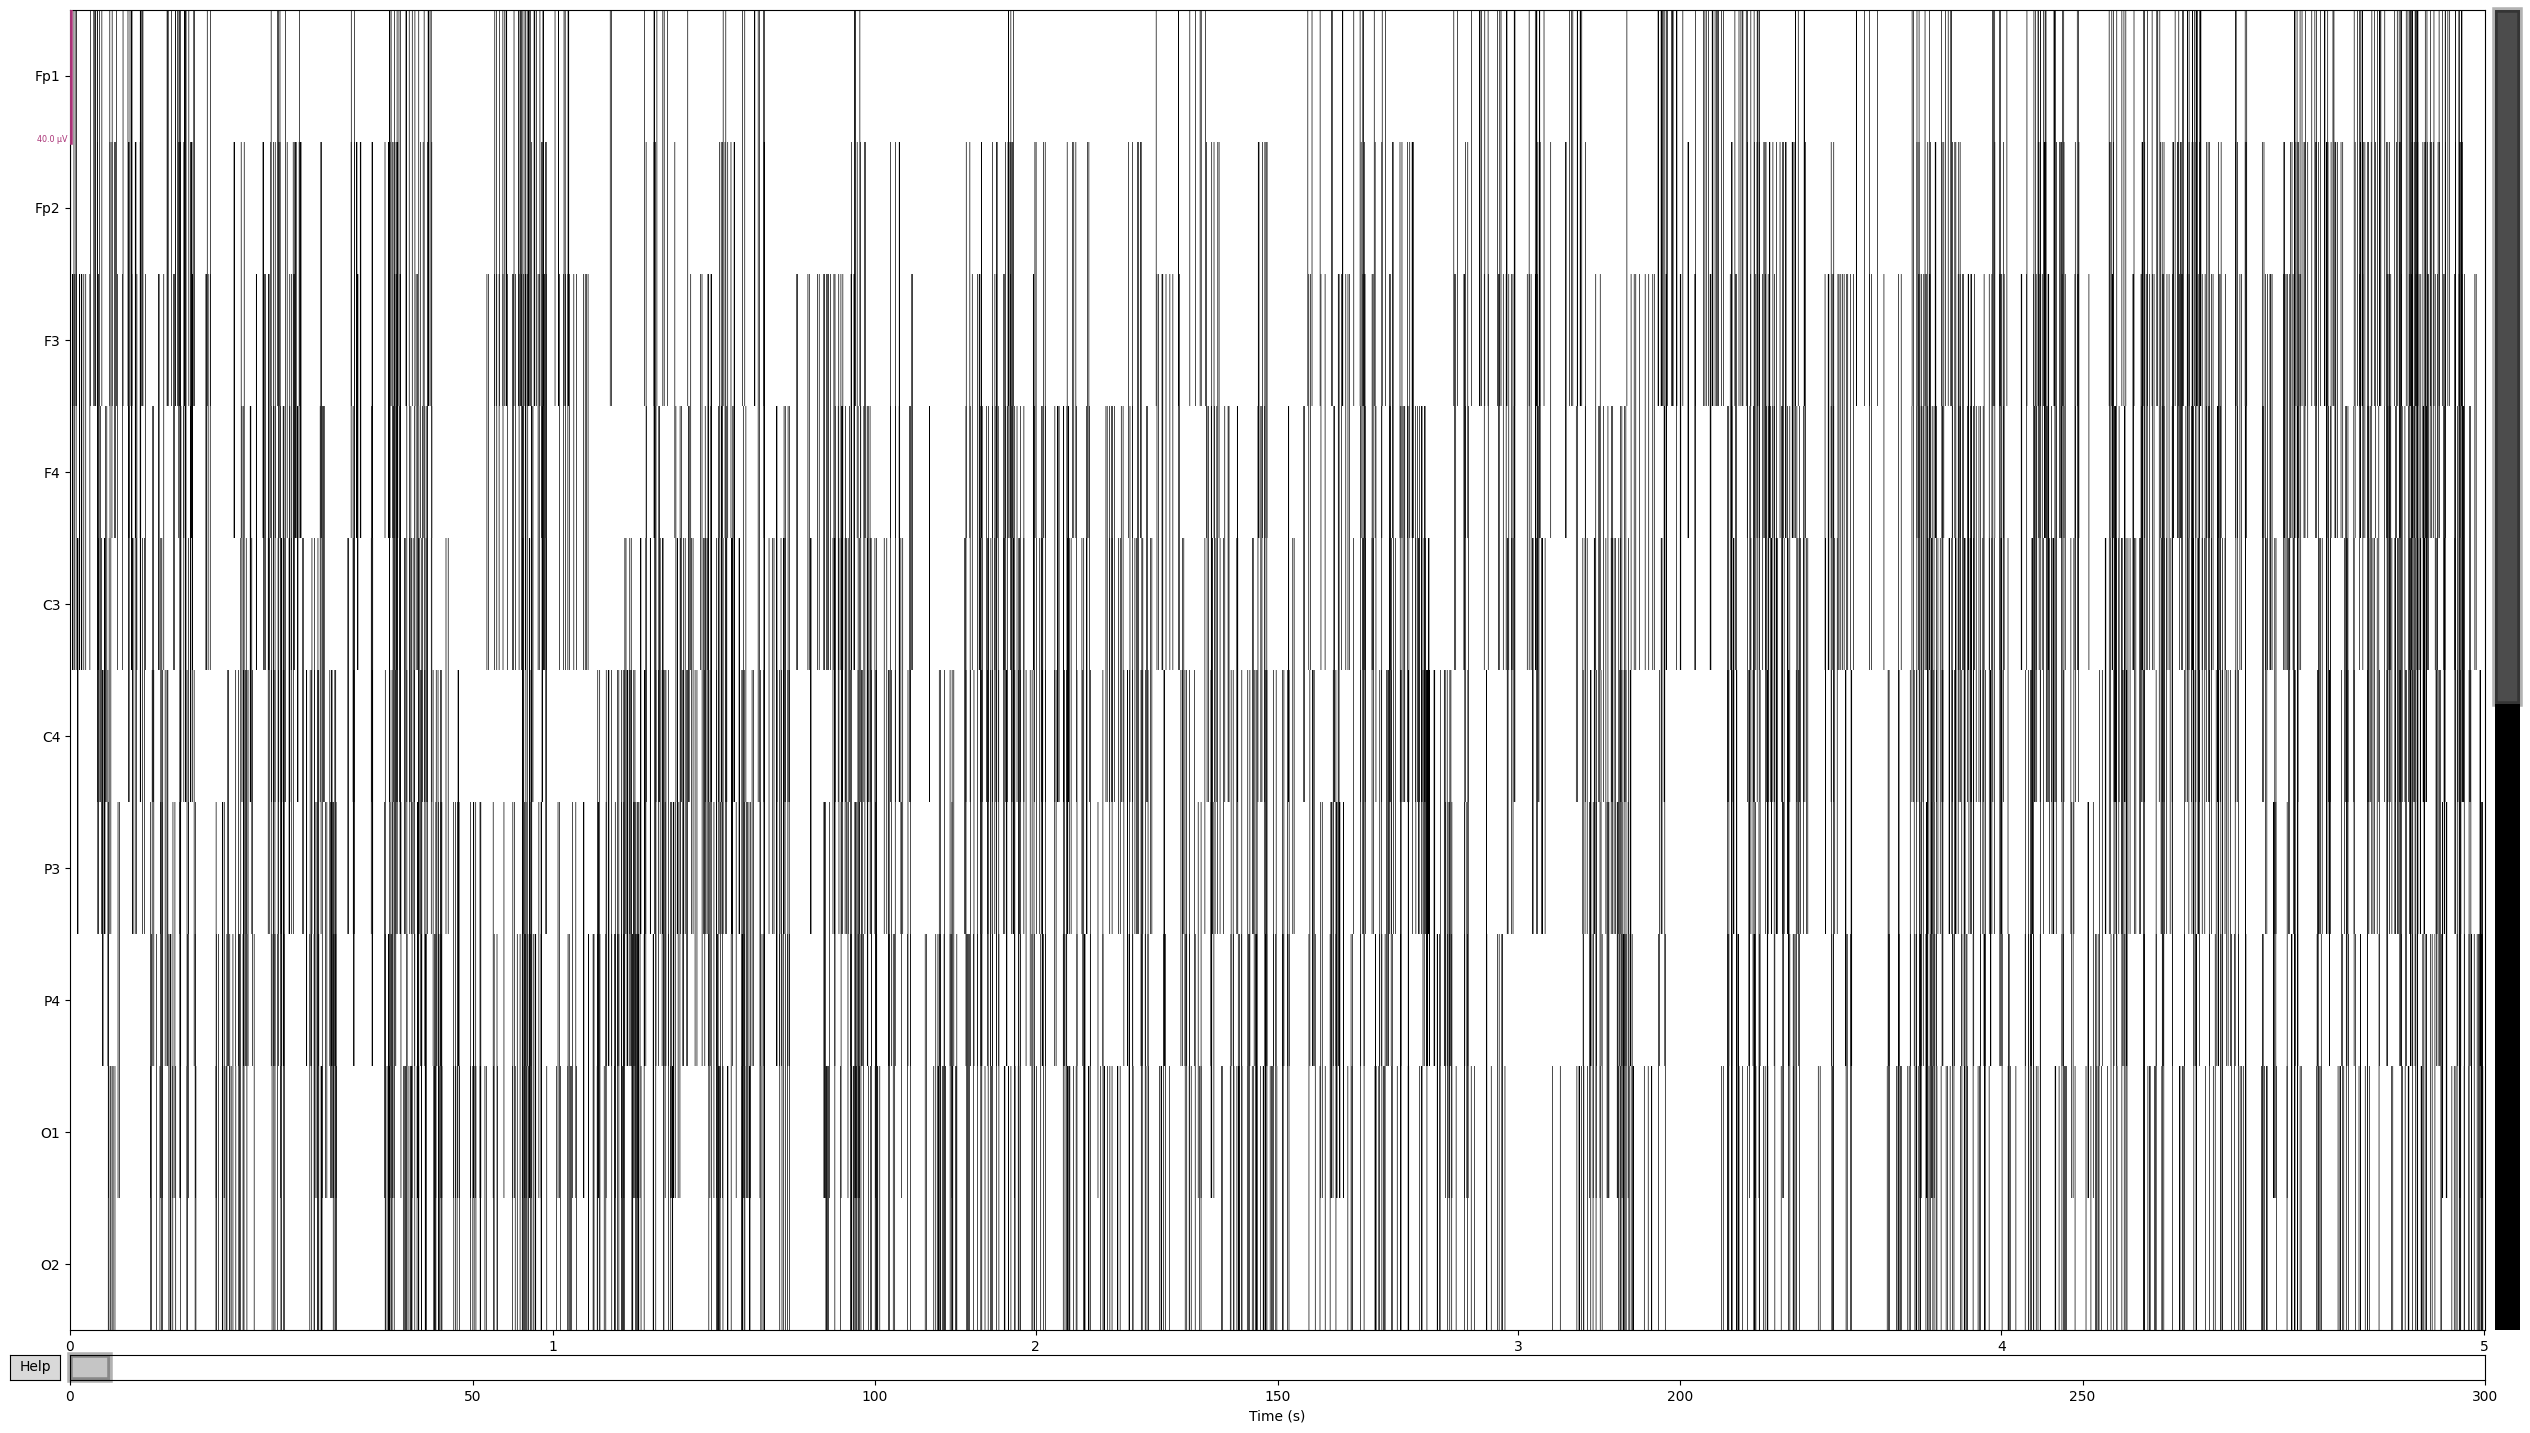

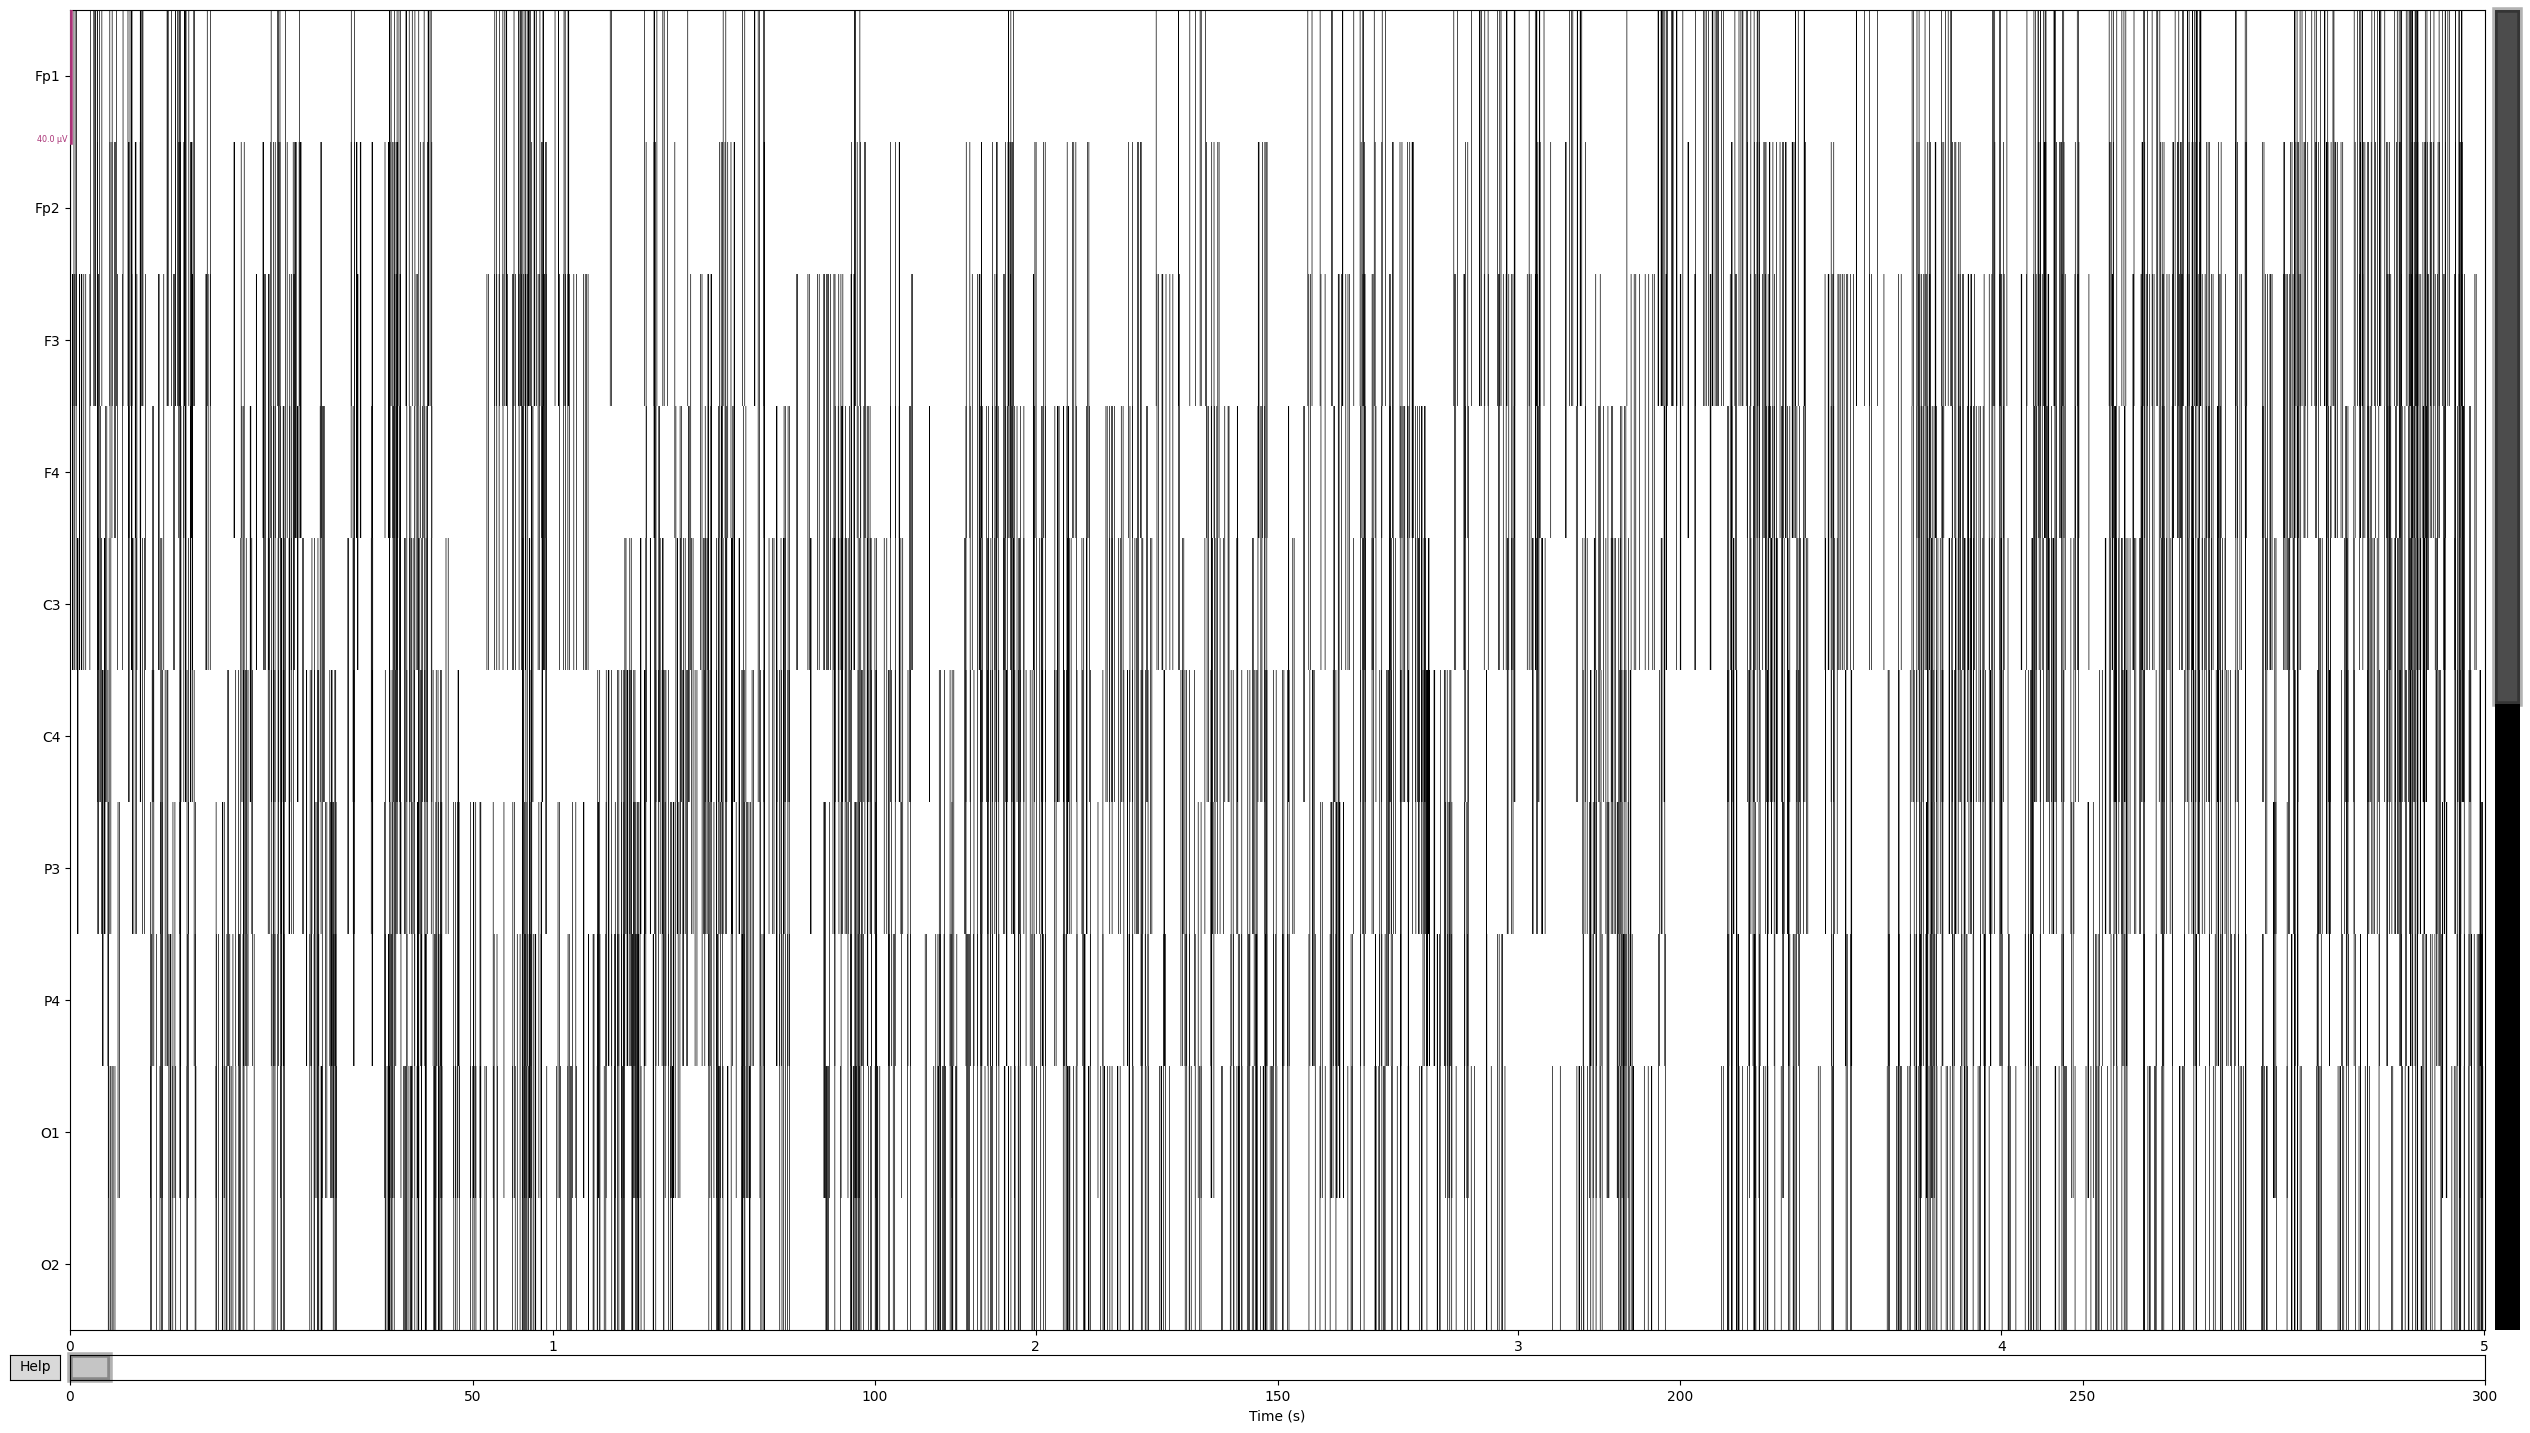

In [208]:
import mne

# Path to the .fif file
file_path = "AllData/OpenNeuroHC/subject_1.fif"  # Update with your actual path

# Load the .fif file
raw = mne.io.read_raw_fif(file_path, preload=True)

# Print basic info
print(raw.info)

# Extract data and inspect
data, times = raw[:, :100]  # Load all channels and all time points
print(f"Data shape: {data.shape} (Channels x Time points)")
print(f"First channel values (first 10 points): {data[0, :50]}")

# Check scale
mean_variance = data.var(axis=1).mean()
print(f"Mean variance across channels: {mean_variance}")
variances = np.var(data, axis=1)
print(f"Channel {raw.ch_names[idx]} variance: {variances}")

# Optional: Visualize
raw.plot(duration=5, n_channels=10, title="EEG Data (Subject 1)")


OpenNeuro pre preprocessing

In [130]:
import os
import mne
import pandas as pd

# Define the input and output directories
input_dir = "AllData/OpenNeuro"
output_dir = "AllData/OpenNeuro/Processed_FIF"

# Create output directory if not exists
os.makedirs(output_dir, exist_ok=True)

# Iterate through the directories
for subject_dir in os.listdir(input_dir):
    subject_path = os.path.join(input_dir, subject_dir, "eeg")
    if not os.path.isdir(subject_path):
        continue  # Skip if not a directory

    eeg_files = [f for f in os.listdir(subject_path) if f.endswith("02_eeg.set")]
    for eeg_file in eeg_files:
        # Define paths for electrode and event files
        electrode_file = os.path.join(subject_path, eeg_file.replace("_eeg.set", "_electrodes.tsv"))
        event_file = os.path.join(subject_path, eeg_file.replace("_eeg.set", "_events.tsv"))

        # Check if files exist
        if not os.path.exists(electrode_file):
            print(f"Missing electrode file for {eeg_file}. Skipping...")
            continue
        if not os.path.exists(event_file):
            print(f"Missing event file for {eeg_file}. Skipping...")
            continue

        # Load the EEG file
        eeg_path = os.path.join(subject_path, eeg_file)
        raw = mne.io.read_raw_eeglab(eeg_path, preload=True)

        # Set montage using the provided function
        raw, bad_channels = set_montage_from_coordinate(raw, electrode_file)

        # Load and process events
        events_df = pd.read_csv(event_file, sep="\t")
        eye_closed_events = events_df[events_df["trial_type"].str.contains("Eyes Closed", na=False)]

        # Extract eye-closed data segments
        for _, event in eye_closed_events.iterrows():
            start_time = event["onset"]
            end_time = start_time + event["duration"]

            # Crop the raw data
            cropped_raw = raw.copy().crop(tmin=start_time, tmax=end_time)

            # Save each segment as a .fif file
            segment_filename = eeg_file.replace("_eeg.set", f"_segment_{int(start_time)}.fif")
            output_path = os.path.join(output_dir, segment_filename)
            cropped_raw.save(output_path, overwrite=True)

        print(f"Processed and saved segments for {eeg_file}.")


Lanzhou pre preprocessing

In [230]:
import os
import numpy as np
from scipy.io import loadmat, whosmat
import mne

# Define paths
input_folder = "AllData/Lanzhou"  # Replace with your input folder
output_folder = "AllData/Lanzhou/Full_FIF"  # Replace with your output folder
os.makedirs(output_folder, exist_ok=True)

# Thresholds
impedance_threshold = 50  # kΩ
rejection_rate_threshold = 0.2  # 20%
min_points = 5 * 60 * 250  # 5 minutes of recording at 250 Hz
amplification_factor = 200  # Define your amplification factor

# Process all .mat files in the folder
for filename in os.listdir(input_folder):
    if filename.endswith(".mat"):
        filepath = os.path.join(input_folder, filename)
        
        # Dynamically get the variable names in the .mat file
        mat_info = whosmat(filepath)
        variable_names = [var[0] for var in mat_info]

        # Attempt to identify relevant variables (EEG data, impedances, and sampling rate)
        data = loadmat(filepath)
        eeg_data_var = next((name for name in variable_names if data[name].ndim == 2), None)
        impedances_var = next((name for name in variable_names if name.lower().startswith("impedance")), None)
        sampling_rate_var = next((name for name in variable_names if "samplingrate" in name.lower()), None)

        # Extract relevant data
        eeg_data = data.get(eeg_data_var)
        impedances = data.get(impedances_var).flatten() if impedances_var else None
        sampling_rate = data.get(sampling_rate_var, 250)  # Default to 250 Hz if not found

        if eeg_data is None or impedances is None:
            print(f"Skipping {filename} due to missing data.")
            continue

        # Ensure the data has at least 5 minutes of recording
        if eeg_data.shape[1] < min_points:
            print(f"Skipping {filename} due to insufficient recording length.")
            continue

        # Keep only the first 5 minutes of data and drop the last channel
        eeg_data = eeg_data[:-1, :min_points]  # Drop the last channel and trim to 5 minutes
        impedances = impedances[:-1]  # Drop the last channel's impedance

        # Apply amplification
        eeg_data *= amplification_factor

        # Convert scaling from microvolts (µV) to volts (V)
        eeg_data = eeg_data / 1e3

        # Identify bad channels based on impedance
        bad_channels = np.where(impedances > impedance_threshold)[0]
        rejection_rate = len(bad_channels) / len(impedances)

        if rejection_rate > rejection_rate_threshold:
            print(f"Rejecting {filename} due to high rejection rate: {rejection_rate:.2%}")
            continue

        # Load the GSN-HydroCel-128 montage
        montage = mne.channels.make_standard_montage("GSN-HydroCel-128")

        # Get channel names from the montage
        montage_ch_names = montage.ch_names

        # Create MNE info object
        ch_names = montage_ch_names[:len(eeg_data)]  # Ensure channel names match the data dimension
        ch_types = ["eeg"] * len(ch_names)  # Assuming all channels are EEG
        info = mne.create_info(ch_names=ch_names, sfreq=sampling_rate, ch_types=ch_types)

        # Create the MNE Raw object
        raw = mne.io.RawArray(eeg_data, info)  # Convert from µV to V

        # Set the montage to the raw object
        raw.set_montage(montage, on_missing="ignore")
        print(f"Applied GSN-HydroCel-128 montage with renamed channels.")

        # Interpolate bad channels
        raw.info["bads"] = [ch_names[i] for i in bad_channels]
        raw.interpolate_bads(reset_bads=True)

        # Save to .fif format
        output_filepath = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}.fif")
        raw.save(output_filepath, overwrite=True)

        print(f"Processed and saved: {output_filepath}")


Creating RawArray with float64 data, n_channels=128, n_times=75000
    Range : 0 ... 74999 =      0.000 ...   299.996 secs
Ready.
Applied GSN-HydroCel-128 montage with renamed channels.
Setting channel interpolation method to {'eeg': 'spline'}.
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010010rest 20150624 1447..fif


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/311568340.py:84: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads(reset_bads=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/311568340.py:88: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010010rest 20150624 1447..fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_filepath, overwrite=True)


Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010010rest 20150624 1447..fif
[done]
Processed and saved: AllData/Lanzhou/Full_FIF/02010010rest 20150624 1447..fif
Creating RawArray with float64 data, n_channels=128, n_times=75000
    Range : 0 ... 74999 =      0.000 ...   299.996 secs
Ready.
Applied GSN-HydroCel-128 montage with renamed channels.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 120 sensor positions
Interpolating 8 sensors
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010030rest 20160324 1054..fif


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/311568340.py:88: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010030rest 20160324 1054..fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_filepath, overwrite=True)


Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010030rest 20160324 1054..fif
[done]
Processed and saved: AllData/Lanzhou/Full_FIF/02010030rest 20160324 1054..fif
Creating RawArray with float64 data, n_channels=128, n_times=75000
    Range : 0 ... 74999 =      0.000 ...   299.996 secs
Ready.
Applied GSN-HydroCel-128 montage with renamed channels.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 126 sensor positions
Interpolating 2 sensors
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020018rest 20150702 1651..fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020018rest 20150702 1651..fif
[done]


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/311568340.py:88: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020018rest 20150702 1651..fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_filepath, overwrite=True)


Processed and saved: AllData/Lanzhou/Full_FIF/02020018rest 20150702 1651..fif
Creating RawArray with float64 data, n_channels=128, n_times=75000
    Range : 0 ... 74999 =      0.000 ...   299.996 secs
Ready.
Applied GSN-HydroCel-128 montage with renamed channels.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 124 sensor positions
Interpolating 4 sensors
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010024rest 20150814 1504..fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010024rest 20150814 1504..fif
[done]


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/311568340.py:88: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010024rest 20150814 1504..fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_filepath, overwrite=True)


Processed and saved: AllData/Lanzhou/Full_FIF/02010024rest 20150814 1504..fif
Rejecting 02030006_rest 20151103 1725.mat due to high rejection rate: 20.31%
Creating RawArray with float64 data, n_channels=128, n_times=75000
    Range : 0 ... 74999 =      0.000 ...   299.996 secs
Ready.
Applied GSN-HydroCel-128 montage with renamed channels.
Setting channel interpolation method to {'eeg': 'spline'}.
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010028rest 20160317 1538..fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010028rest 20160317 1538..fif


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/311568340.py:84: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads(reset_bads=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/311568340.py:88: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010028rest 20160317 1538..fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_filepath, overwrite=True)


[done]
Processed and saved: AllData/Lanzhou/Full_FIF/02010028rest 20160317 1538..fif
Creating RawArray with float64 data, n_channels=128, n_times=75000
    Range : 0 ... 74999 =      0.000 ...   299.996 secs
Ready.
Applied GSN-HydroCel-128 montage with renamed channels.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 121 sensor positions
Interpolating 7 sensors
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020019rest 20150703 1036..fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020019rest 20150703 1036..fif
[done]


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/311568340.py:88: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020019rest 20150703 1036..fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_filepath, overwrite=True)


Processed and saved: AllData/Lanzhou/Full_FIF/02020019rest 20150703 1036..fif
Creating RawArray with float64 data, n_channels=128, n_times=75000
    Range : 0 ... 74999 =      0.000 ...   299.996 secs
Ready.
Applied GSN-HydroCel-128 montage with renamed channels.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 126 sensor positions
Interpolating 2 sensors
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02030003_rest 20151022 1155.fif


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/311568340.py:88: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02030003_rest 20151022 1155.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_filepath, overwrite=True)


Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02030003_rest 20151022 1155.fif
[done]
Processed and saved: AllData/Lanzhou/Full_FIF/02030003_rest 20151022 1155.fif
Creating RawArray with float64 data, n_channels=128, n_times=75000
    Range : 0 ... 74999 =      0.000 ...   299.996 secs
Ready.
Applied GSN-HydroCel-128 montage with renamed channels.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 125 sensor positions
Interpolating 3 sensors
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020027rest 20150713 1049..fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020027rest 20150713 1049..fif
[done]


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/311568340.py:88: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020027rest 20150713 1049..fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_filepath, overwrite=True)


Processed and saved: AllData/Lanzhou/Full_FIF/02020027rest 20150713 1049..fif
Skipping 02030014rest 20151117 1441..mat due to missing data.
Creating RawArray with float64 data, n_channels=128, n_times=75000
    Range : 0 ... 74999 =      0.000 ...   299.996 secs
Ready.
Applied GSN-HydroCel-128 montage with renamed channels.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 122 sensor positions
Interpolating 6 sensors
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010033rest 20160331 1239..fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010033rest 20160331 1239..fif
[done]


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/311568340.py:88: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010033rest 20160331 1239..fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_filepath, overwrite=True)


Processed and saved: AllData/Lanzhou/Full_FIF/02010033rest 20160331 1239..fif
Creating RawArray with float64 data, n_channels=128, n_times=75000
    Range : 0 ... 74999 =      0.000 ...   299.996 secs
Ready.
Applied GSN-HydroCel-128 montage with renamed channels.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 124 sensor positions
Interpolating 4 sensors
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020020rest 20150703 1754..fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020020rest 20150703 1754..fif
[done]


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/311568340.py:88: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020020rest 20150703 1754..fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_filepath, overwrite=True)


Processed and saved: AllData/Lanzhou/Full_FIF/02020020rest 20150703 1754..fif
Rejecting 02030004_rest 20151026 1930.mat due to high rejection rate: 28.91%
Creating RawArray with float64 data, n_channels=128, n_times=75000
    Range : 0 ... 74999 =      0.000 ...   299.996 secs
Ready.
Applied GSN-HydroCel-128 montage with renamed channels.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 112 sensor positions
Interpolating 16 sensors
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02030018_rest 20151208 1443.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02030018_rest 20151208 1443.fif
[done]
Processed and saved: AllData/Lanzhou/Full_FIF/02030018_rest 20151208 1443.fif
Creating RawArray with float64 data, n_channels=128, n_times=75000
    Range : 0 ... 74999 =      0.000 ...   299.996 secs
Ready.

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/311568340.py:88: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02030018_rest 20151208 1443.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_filepath, overwrite=True)


Applied GSN-HydroCel-128 montage with renamed channels.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 113 sensor positions
Interpolating 15 sensors
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020022rest 20150707 1452..fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020022rest 20150707 1452..fif
[done]


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/311568340.py:88: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020022rest 20150707 1452..fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_filepath, overwrite=True)


Processed and saved: AllData/Lanzhou/Full_FIF/02020022rest 20150707 1452..fif
Creating RawArray with float64 data, n_channels=128, n_times=75000
    Range : 0 ... 74999 =      0.000 ...   299.996 secs
Ready.
Applied GSN-HydroCel-128 montage with renamed channels.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 123 sensor positions
Interpolating 5 sensors
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020015_rest 20150630 1527.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020015_rest 20150630 1527.fif
[done]


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/311568340.py:88: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020015_rest 20150630 1527.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_filepath, overwrite=True)


Processed and saved: AllData/Lanzhou/Full_FIF/02020015_rest 20150630 1527.fif
Creating RawArray with float64 data, n_channels=128, n_times=75000
    Range : 0 ... 74999 =      0.000 ...   299.996 secs
Ready.
Applied GSN-HydroCel-128 montage with renamed channels.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 124 sensor positions
Interpolating 4 sensors
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020010rest 20150625 1224..fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020010rest 20150625 1224..fif
[done]


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/311568340.py:88: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020010rest 20150625 1224..fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_filepath, overwrite=True)


Processed and saved: AllData/Lanzhou/Full_FIF/02020010rest 20150625 1224..fif
Creating RawArray with float64 data, n_channels=128, n_times=75000
    Range : 0 ... 74999 =      0.000 ...   299.996 secs
Ready.
Applied GSN-HydroCel-128 montage with renamed channels.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 116 sensor positions
Interpolating 12 sensors
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010026rest 20160311 1421..fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010026rest 20160311 1421..fif
[done]


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/311568340.py:88: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010026rest 20160311 1421..fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_filepath, overwrite=True)


Processed and saved: AllData/Lanzhou/Full_FIF/02010026rest 20160311 1421..fif
Rejecting 02010021 20150805 1730.mat.mat due to high rejection rate: 25.00%
Creating RawArray with float64 data, n_channels=128, n_times=75000
    Range : 0 ... 74999 =      0.000 ...   299.996 secs
Ready.
Applied GSN-HydroCel-128 montage with renamed channels.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 127 sensor positions
Interpolating 1 sensors
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02030002rest_new 20151022 1.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02030002rest_new 20151022 1.fif
[done]


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/311568340.py:88: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02030002rest_new 20151022 1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_filepath, overwrite=True)


Processed and saved: AllData/Lanzhou/Full_FIF/02030002rest_new 20151022 1.fif
Creating RawArray with float64 data, n_channels=128, n_times=75000
    Range : 0 ... 74999 =      0.000 ...   299.996 secs
Ready.
Applied GSN-HydroCel-128 montage with renamed channels.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 124 sensor positions
Interpolating 4 sensors
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010008_rest 20150619 1653.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010008_rest 20150619 1653.fif
[done]


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/311568340.py:88: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010008_rest 20150619 1653.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_filepath, overwrite=True)


Processed and saved: AllData/Lanzhou/Full_FIF/02010008_rest 20150619 1653.fif
Creating RawArray with float64 data, n_channels=128, n_times=75000
    Range : 0 ... 74999 =      0.000 ...   299.996 secs
Ready.
Applied GSN-HydroCel-128 montage with renamed channels.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 106 sensor positions
Interpolating 22 sensors
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020029rest 20150715 1316..fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020029rest 20150715 1316..fif
[done]


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/311568340.py:88: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020029rest 20150715 1316..fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_filepath, overwrite=True)


Processed and saved: AllData/Lanzhou/Full_FIF/02020029rest 20150715 1316..fif
Creating RawArray with float64 data, n_channels=128, n_times=75000
    Range : 0 ... 74999 =      0.000 ...   299.996 secs
Ready.
Applied GSN-HydroCel-128 montage with renamed channels.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 123 sensor positions
Interpolating 5 sensors
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020014_rest 20150630 1023.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020014_rest 20150630 1023.fif
[done]


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/311568340.py:88: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020014_rest 20150630 1023.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_filepath, overwrite=True)


Processed and saved: AllData/Lanzhou/Full_FIF/02020014_rest 20150630 1023.fif
Creating RawArray with float64 data, n_channels=128, n_times=75000
    Range : 0 ... 74999 =      0.000 ...   299.996 secs
Ready.
Applied GSN-HydroCel-128 montage with renamed channels.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 111 sensor positions
Interpolating 17 sensors
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010025 20160311 1206.mat.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010025 20160311 1206.mat.fif
[done]
Processed and saved: AllData/Lanzhou/Full_FIF/02010025 20160311 1206.mat.fif
Creating RawArray with float64 data, n_channels=128, n_times=75000
    Range : 0 ... 74999 =      0.000 ...   299.996 secs
Ready.


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/311568340.py:88: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010025 20160311 1206.mat.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_filepath, overwrite=True)


Applied GSN-HydroCel-128 montage with renamed channels.
Setting channel interpolation method to {'eeg': 'spline'}.
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020021rest 20150707 1720..fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020021rest 20150707 1720..fif
[done]
Processed and saved: AllData/Lanzhou/Full_FIF/02020021rest 20150707 1720..fif
Creating RawArray with float64 data, n_channels=128, n_times=75000
    Range : 0 ... 74999 =      0.000 ...   299.996 secs
Ready.
Applied GSN-HydroCel-128 montage with renamed channels.
Setting channel interpolation method to {'eeg': 'spline'}.


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/311568340.py:84: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads(reset_bads=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/311568340.py:88: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020021rest 20150707 1720..fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_filepath, overwrite=True)


Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 123 sensor positions
Interpolating 5 sensors
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020026_rest 20150714 1413.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020026_rest 20150714 1413.fif
[done]


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/311568340.py:88: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020026_rest 20150714 1413.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_filepath, overwrite=True)


Processed and saved: AllData/Lanzhou/Full_FIF/02020026_rest 20150714 1413.fif
Creating RawArray with float64 data, n_channels=128, n_times=75000
    Range : 0 ... 74999 =      0.000 ...   299.996 secs
Ready.
Applied GSN-HydroCel-128 montage with renamed channels.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 119 sensor positions
Interpolating 9 sensors
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010019rest 20150716 1440..fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010019rest 20150716 1440..fif
[done]


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/311568340.py:88: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010019rest 20150716 1440..fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_filepath, overwrite=True)


Processed and saved: AllData/Lanzhou/Full_FIF/02010019rest 20150716 1440..fif
Rejecting 02010013rest 20150703 1333..mat due to high rejection rate: 20.31%
Creating RawArray with float64 data, n_channels=128, n_times=75000
    Range : 0 ... 74999 =      0.000 ...   299.996 secs
Ready.
Applied GSN-HydroCel-128 montage with renamed channels.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 126 sensor positions
Interpolating 2 sensors
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020013rest 20150629 1607..fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020013rest 20150629 1607..fif
[done]


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/311568340.py:88: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020013rest 20150629 1607..fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_filepath, overwrite=True)


Processed and saved: AllData/Lanzhou/Full_FIF/02020013rest 20150629 1607..fif
Creating RawArray with float64 data, n_channels=128, n_times=75000
    Range : 0 ... 74999 =      0.000 ...   299.996 secs
Ready.
Applied GSN-HydroCel-128 montage with renamed channels.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 127 sensor positions
Interpolating 1 sensors
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010005rest 20150507 0907..fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010005rest 20150507 0907..fif
[done]


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/311568340.py:88: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010005rest 20150507 0907..fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_filepath, overwrite=True)


Processed and saved: AllData/Lanzhou/Full_FIF/02010005rest 20150507 0907..fif
Rejecting 02010016rest 20150710 1220..mat due to high rejection rate: 24.22%
Creating RawArray with float64 data, n_channels=128, n_times=75000
    Range : 0 ... 74999 =      0.000 ...   299.996 secs
Ready.
Applied GSN-HydroCel-128 montage with renamed channels.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 127 sensor positions
Interpolating 1 sensors
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010023rest 20150729 1929..fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010023rest 20150729 1929..fif
[done]


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/311568340.py:88: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010023rest 20150729 1929..fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_filepath, overwrite=True)


Processed and saved: AllData/Lanzhou/Full_FIF/02010023rest 20150729 1929..fif
Rejecting 02010002rest201504161017..mat due to high rejection rate: 27.34%
Skipping 02030020_rest 20151230 1416.mat due to missing data.
Creating RawArray with float64 data, n_channels=128, n_times=75000
    Range : 0 ... 74999 =      0.000 ...   299.996 secs
Ready.
Applied GSN-HydroCel-128 montage with renamed channels.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 126 sensor positions
Interpolating 2 sensors
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010006rest 20150528 0928..fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010006rest 20150528 0928..fif
[done]


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/311568340.py:88: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010006rest 20150528 0928..fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_filepath, overwrite=True)


Processed and saved: AllData/Lanzhou/Full_FIF/02010006rest 20150528 0928..fif
Creating RawArray with float64 data, n_channels=128, n_times=75000
    Range : 0 ... 74999 =      0.000 ...   299.996 secs
Ready.
Applied GSN-HydroCel-128 montage with renamed channels.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 123 sensor positions
Interpolating 5 sensors
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020025rest 20150713 1519..fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020025rest 20150713 1519..fif
[done]


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/311568340.py:88: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020025rest 20150713 1519..fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_filepath, overwrite=True)


Processed and saved: AllData/Lanzhou/Full_FIF/02020025rest 20150713 1519..fif
Rejecting 02010036_rest 20160408 1418.mat due to high rejection rate: 20.31%
Creating RawArray with float64 data, n_channels=128, n_times=75000
    Range : 0 ... 74999 =      0.000 ...   299.996 secs
Ready.
Applied GSN-HydroCel-128 montage with renamed channels.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 111 sensor positions
Interpolating 17 sensors
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010034rest 20160407 0938..fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010034rest 20160407 0938..fif
[done]


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/311568340.py:88: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010034rest 20160407 0938..fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_filepath, overwrite=True)


Processed and saved: AllData/Lanzhou/Full_FIF/02010034rest 20160407 0938..fif
Creating RawArray with float64 data, n_channels=128, n_times=75000
    Range : 0 ... 74999 =      0.000 ...   299.996 secs
Ready.
Applied GSN-HydroCel-128 montage with renamed channels.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 124 sensor positions
Interpolating 4 sensors
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02030021rest 20160105 1141..fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02030021rest 20160105 1141..fif
[done]


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/311568340.py:88: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02030021rest 20160105 1141..fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_filepath, overwrite=True)


Processed and saved: AllData/Lanzhou/Full_FIF/02030021rest 20160105 1141..fif
Creating RawArray with float64 data, n_channels=128, n_times=75000
    Range : 0 ... 74999 =      0.000 ...   299.996 secs
Ready.
Applied GSN-HydroCel-128 montage with renamed channels.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 112 sensor positions
Interpolating 16 sensors
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010012rest 20150626 1026..fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010012rest 20150626 1026..fif
[done]


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/311568340.py:88: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010012rest 20150626 1026..fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_filepath, overwrite=True)


Processed and saved: AllData/Lanzhou/Full_FIF/02010012rest 20150626 1026..fif
Creating RawArray with float64 data, n_channels=128, n_times=75000
    Range : 0 ... 74999 =      0.000 ...   299.996 secs
Ready.
Applied GSN-HydroCel-128 montage with renamed channels.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 124 sensor positions
Interpolating 4 sensors
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010018rest 20150716 1237..fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010018rest 20150716 1237..fif
[done]


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/311568340.py:88: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010018rest 20150716 1237..fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_filepath, overwrite=True)


Processed and saved: AllData/Lanzhou/Full_FIF/02010018rest 20150716 1237..fif
Rejecting 02030007_rest 20151103 2032.mat due to high rejection rate: 44.53%
Creating RawArray with float64 data, n_channels=128, n_times=75000
    Range : 0 ... 74999 =      0.000 ...   299.996 secs
Ready.
Applied GSN-HydroCel-128 montage with renamed channels.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 126 sensor positions
Interpolating 2 sensors
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02030019_rest 20151230 1314.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02030019_rest 20151230 1314.fif
[done]


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/311568340.py:88: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02030019_rest 20151230 1314.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_filepath, overwrite=True)


Processed and saved: AllData/Lanzhou/Full_FIF/02030019_rest 20151230 1314.fif
Creating RawArray with float64 data, n_channels=128, n_times=75000
    Range : 0 ... 74999 =      0.000 ...   299.996 secs
Ready.
Applied GSN-HydroCel-128 montage with renamed channels.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 122 sensor positions
Interpolating 6 sensors
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02030005rest 20151026 2103..fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02030005rest 20151026 2103..fif
[done]


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/311568340.py:88: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02030005rest 20151026 2103..fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_filepath, overwrite=True)


Processed and saved: AllData/Lanzhou/Full_FIF/02030005rest 20151026 2103..fif
Skipping 02030009_rest 20151105 1113.mat due to missing data.
Creating RawArray with float64 data, n_channels=128, n_times=75000
    Range : 0 ... 74999 =      0.000 ...   299.996 secs
Ready.
Applied GSN-HydroCel-128 montage with renamed channels.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 126 sensor positions
Interpolating 2 sensors
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020008rest 20150624 1711..fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020008rest 20150624 1711..fif
[done]


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/311568340.py:88: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020008rest 20150624 1711..fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_filepath, overwrite=True)


Processed and saved: AllData/Lanzhou/Full_FIF/02020008rest 20150624 1711..fif
Rejecting 02010015rest 20150709 1456..mat due to high rejection rate: 28.91%
Creating RawArray with float64 data, n_channels=128, n_times=75000
    Range : 0 ... 74999 =      0.000 ...   299.996 secs
Ready.
Applied GSN-HydroCel-128 montage with renamed channels.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 124 sensor positions
Interpolating 4 sensors
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020016rest 20150701 1040..fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020016rest 20150701 1040..fif
[done]


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/311568340.py:88: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020016rest 20150701 1040..fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_filepath, overwrite=True)


Processed and saved: AllData/Lanzhou/Full_FIF/02020016rest 20150701 1040..fif
Creating RawArray with float64 data, n_channels=128, n_times=75000
    Range : 0 ... 74999 =      0.000 ...   299.996 secs
Ready.
Applied GSN-HydroCel-128 montage with renamed channels.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 123 sensor positions
Interpolating 5 sensors
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020023restnew 20150709 10.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020023restnew 20150709 10.fif
[done]


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/311568340.py:88: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02020023restnew 20150709 10.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_filepath, overwrite=True)


Processed and saved: AllData/Lanzhou/Full_FIF/02020023restnew 20150709 10.fif
Creating RawArray with float64 data, n_channels=128, n_times=75000
    Range : 0 ... 74999 =      0.000 ...   299.996 secs
Ready.
Applied GSN-HydroCel-128 montage with renamed channels.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 126 sensor positions
Interpolating 2 sensors
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010004rest 20150427 1335..fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010004rest 20150427 1335..fif
[done]


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/311568340.py:88: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010004rest 20150427 1335..fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_filepath, overwrite=True)


Processed and saved: AllData/Lanzhou/Full_FIF/02010004rest 20150427 1335..fif
Creating RawArray with float64 data, n_channels=128, n_times=75000
    Range : 0 ... 74999 =      0.000 ...   299.996 secs
Ready.
Applied GSN-HydroCel-128 montage with renamed channels.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 119 sensor positions
Interpolating 9 sensors
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010022restnew 20150724 14.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010022restnew 20150724 14.fif
[done]


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/311568340.py:88: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010022restnew 20150724 14.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_filepath, overwrite=True)


Processed and saved: AllData/Lanzhou/Full_FIF/02010022restnew 20150724 14.fif
Creating RawArray with float64 data, n_channels=128, n_times=75000
    Range : 0 ... 74999 =      0.000 ...   299.996 secs
Ready.
Applied GSN-HydroCel-128 montage with renamed channels.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 127 sensor positions
Interpolating 1 sensors
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010011rest 20150625 1516..fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010011rest 20150625 1516..fif
[done]


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/311568340.py:88: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02010011rest 20150625 1516..fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_filepath, overwrite=True)


Processed and saved: AllData/Lanzhou/Full_FIF/02010011rest 20150625 1516..fif
Creating RawArray with float64 data, n_channels=128, n_times=75000
    Range : 0 ... 74999 =      0.000 ...   299.996 secs
Ready.
Applied GSN-HydroCel-128 montage with renamed channels.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 113 sensor positions
Interpolating 15 sensors
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02030017_rest 20151208 1329.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02030017_rest 20151208 1329.fif
[done]
Processed and saved: AllData/Lanzhou/Full_FIF/02030017_rest 20151208 1329.fif


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/311568340.py:88: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Lanzhou/Full_FIF/02030017_rest 20151208 1329.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_filepath, overwrite=True)


Opening raw data file AllData/Lanzhou/Full_FIF/02020019rest 20150703 1036..fif...
    Range : 0 ... 74999 =      0.000 ...   299.996 secs
Ready.
Reading 0 ... 74999  =      0.000 ...   299.996 secs...
File: 02020019rest 20150703 1036..fif
<Info | 10 non-empty values
 bads: []
 ch_names: E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12, E13, E14, ...
 chs: 128 EEG
 custom_ref_applied: False
 dig: 131 items (3 Cardinal, 128 EEG)
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 128
 projs: []
 sfreq: 250.0 Hz
>
Data shape: (128, 5000) (Channels x Time points)
Data (first channel): [387.23965454 396.01922607 411.35919189 407.13967896 395.75222778
 397.77426147 405.41525269 414.9730835  410.60766602 398.50811768
 400.32342529 410.32388306 415.73886108 409.72329712 398.56756592
 400.58795166 409.45465088 416.1137085  408.8895874  400.62319946
 401.17724609 411.59912109 417.69351196 411.71020508 401.02340698
 402.38381958 

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/2035023894.py:15: RuntimeWarning: This filename (AllData/Lanzhou/Full_FIF/02020019rest 20150703 1036..fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


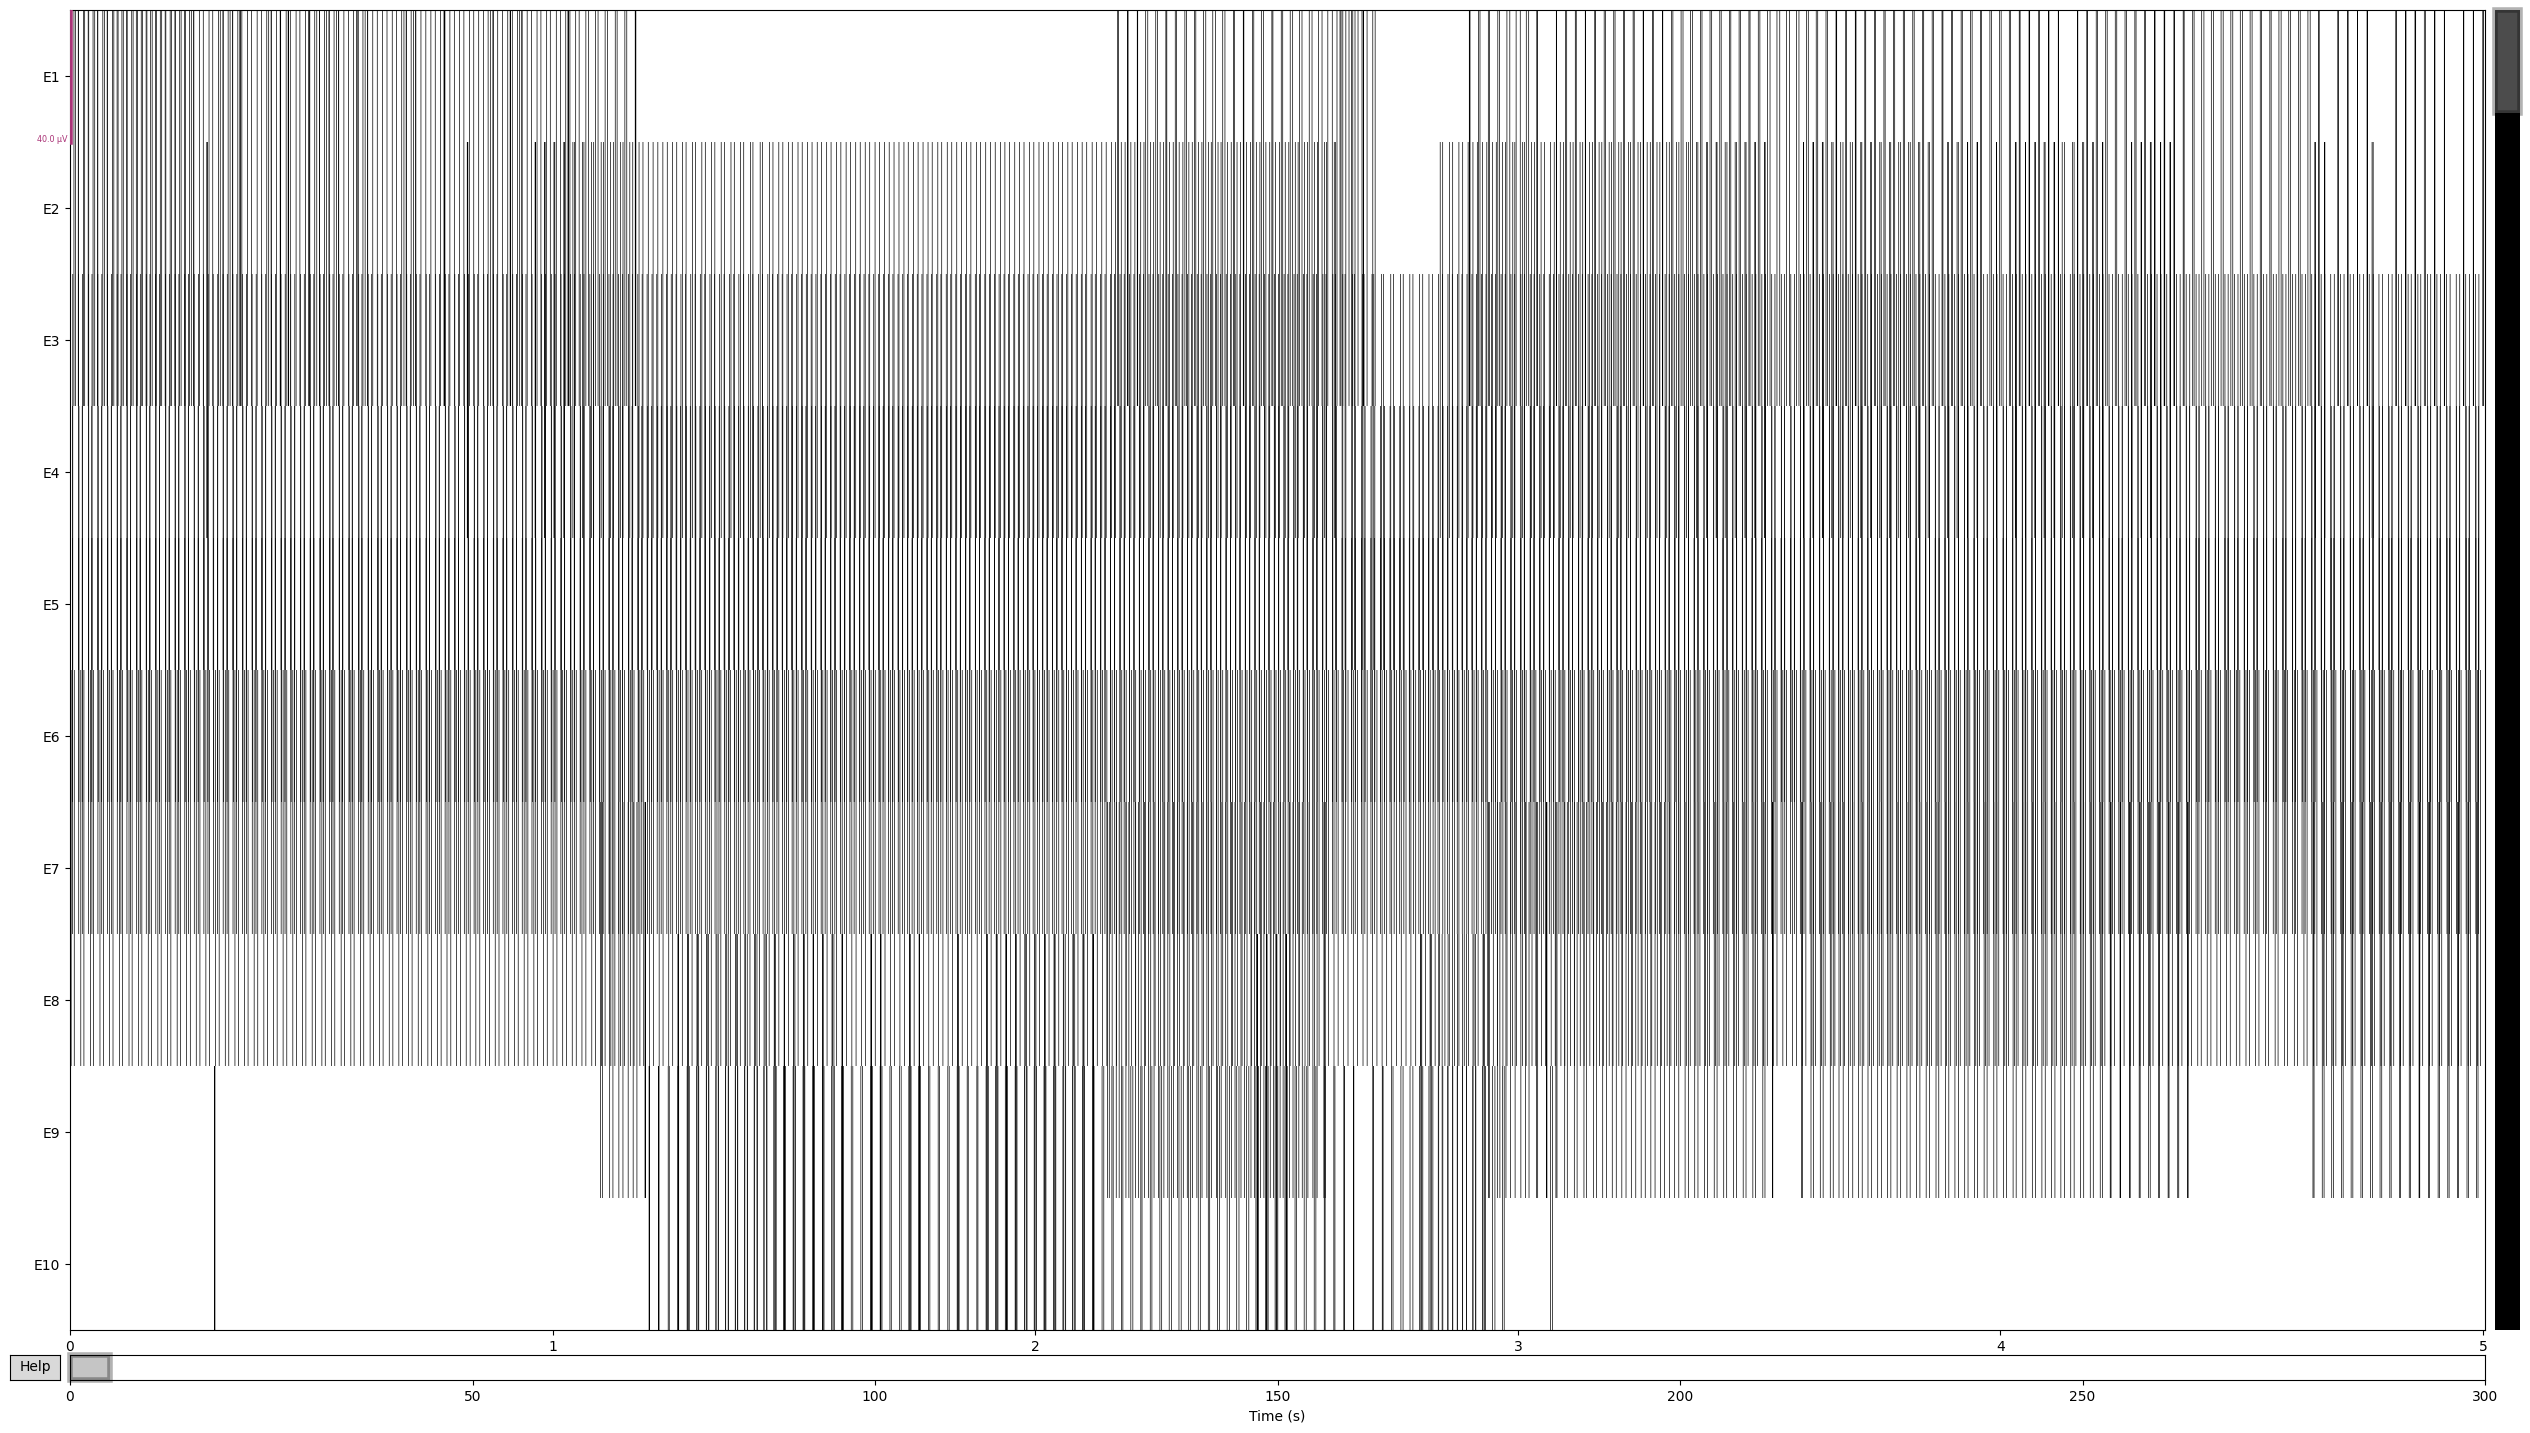

In [231]:
import mne
import os

# Path to your .fif files
fif_folder = "AllData/Lanzhou/Full_FIF"  # Replace with your path

# List all .fif files
fif_files = [f for f in os.listdir(fif_folder) if f.endswith(".fif")]

# Loop through each .fif file to load and inspect
for fif_file in fif_files:
    file_path = os.path.join(fif_folder, fif_file)
    
    # Load the .fif file
    raw = mne.io.read_raw_fif(file_path, preload=True)
    
    # Print basic info
    print(f"File: {fif_file}")
    print(raw.info)
    
    # Inspect the first few seconds of data
    data, times = raw[:, 10000:15000]  # Inspect first 5 seconds (adjust as needed)
    variances = np.var(data, axis=1)
    print(f"Data shape: {data.shape} (Channels x Time points)")
    print(f"Data (first channel): {data[0, :50]}")  # Print first 5 data points of the first channel
    print(f"Channel {raw.ch_names[idx]} variance: {variances}")
    
    # Plot raw data
    raw.plot(duration=5, n_channels=10, title=f"Raw Data - {fif_file}")  # View 10 channels for 5 seconds
    break


Bonferroni Corrected p-values:
Channels: 1.000
Components: 0.265
Variance Explained: 0.253


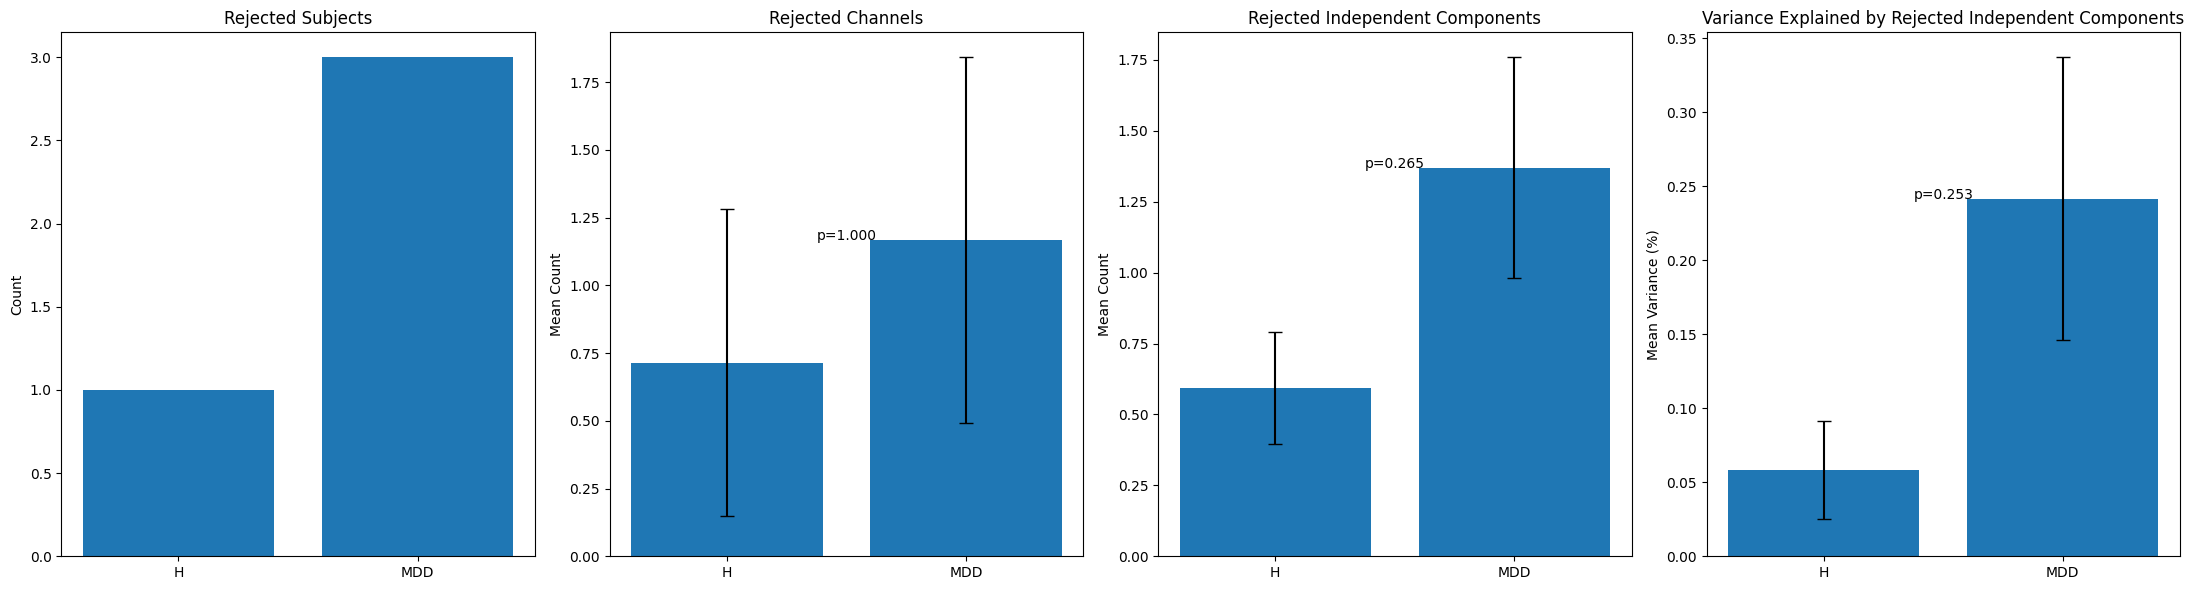

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_ind

# Define the folder path where the logs are stored
folder_path = "AllData/Figshare/Processed_FIF"

# File paths for the logs
rejected_subjects_file = os.path.join(folder_path, "rejected_subjects.txt")
rejected_channels_file = os.path.join(folder_path, "rejected_channels.txt")
rejected_components_file = os.path.join(folder_path, "rejected_components.txt")

# Read the logs
with open(rejected_subjects_file, 'r') as f:
    rejected_subjects = f.readlines()

with open(rejected_channels_file, 'r') as f:
    rejected_channels = [line.strip() for line in f.readlines()]

with open(rejected_components_file, 'r') as f:
    rejected_components = [line.strip() for line in f.readlines()]

# Initialize data storage for groups
data = {"H": {"subjects": 0, "channels": [], "independent components": [], "variance_explained": []},
        "MDD": {"subjects": 0, "channels": [], "independent components": [], "variance_explained": []}}

# Process rejected subjects
for subject in rejected_subjects:
    group = "H" if subject.startswith("H") else "MDD"
    data[group]["subjects"] += 1

# Process rejected channels
for line in rejected_channels:
    if line:
        parts = line.split(": ")
        group = "H" if parts[0].startswith("H") else "MDD"
        channels_list = eval(parts[1]) if len(parts) > 1 and parts[1] else []
        data[group]["channels"].append(len(channels_list))

# Process rejected independent components
for line in rejected_components:
    if line:
        parts = line.split(": ", 1)
        group = "H" if parts[0].startswith("H") else "MDD"
        stats_dict = eval(parts[1]) if len(parts) > 1 else {}
        data[group]["independent components"].append(stats_dict.get('rejected_components', 0))
        data[group]["variance_explained"].append(stats_dict.get('variance_explained', 0))

# Calculate means and standard errors
def calc_stats(data_list):
    return np.mean(data_list), np.std(data_list) / np.sqrt(len(data_list))

stats = {group: {
    "subjects": data[group]["subjects"],
    "channels": calc_stats(data[group]["channels"]),
    "independent components": calc_stats(data[group]["independent components"]),
    "variance_explained": calc_stats(data[group]["variance_explained"]),
} for group in data.keys()}

# Perform statistical tests
p_channels = ttest_ind(data["H"]["channels"], data["MDD"]["channels"], equal_var=False).pvalue
p_components = ttest_ind(data["H"]["independent components"], data["MDD"]["independent components"], equal_var=False).pvalue
p_variance = ttest_ind(data["H"]["variance_explained"], data["MDD"]["variance_explained"], equal_var=False).pvalue

# Apply Bonferroni correction
p_values = [p_channels, p_components, p_variance]
bonferroni_corrected = multipletests(p_values, method='bonferroni')[1]

# Print corrected p-values
print("Bonferroni Corrected p-values:")
print(f"Channels: {bonferroni_corrected[0]:.3f}")
print(f"Components: {bonferroni_corrected[1]:.3f}")
print(f"Variance Explained: {bonferroni_corrected[2]:.3f}")

# Plot the results
fig, axes = plt.subplots(1, 4, figsize=(22, 6))

# Rejected Subjects
axes[0].bar(["H", "MDD"], [stats["H"]["subjects"], stats["MDD"]["subjects"]])
axes[0].set_title("Rejected Subjects")
axes[0].set_ylabel("Count")

# Rejected Channels
axes[1].bar(["H", "MDD"], [stats["H"]["channels"][0], stats["MDD"]["channels"][0]],
            yerr=[stats["H"]["channels"][1], stats["MDD"]["channels"][1]], capsize=5)
axes[1].set_title("Rejected Channels")
axes[1].set_ylabel("Mean Count")
axes[1].text(0.5, max(stats["H"]["channels"][0], stats["MDD"]["channels"][0]),
             f"p={bonferroni_corrected[0]:.3f}", ha='center')

# Rejected Components
axes[2].bar(["H", "MDD"], [stats["H"]["independent components"][0], stats["MDD"]["independent components"][0]],
            yerr=[stats["H"]["independent components"][1], stats["MDD"]["independent components"][1]], capsize=5)
axes[2].set_title("Rejected Independent Components")
axes[2].set_ylabel("Mean Count")
axes[2].text(0.5, max(stats["H"]["independent components"][0], stats["MDD"]["independent components"][0]),
             f"p={bonferroni_corrected[1]:.3f}", ha='center')

# Variance Explained by Rejected Components
axes[3].bar(["H", "MDD"], [stats["H"]["variance_explained"][0], stats["MDD"]["variance_explained"][0]],
            yerr=[stats["H"]["variance_explained"][1], stats["MDD"]["variance_explained"][1]], capsize=5)
axes[3].set_title("Variance Explained by Rejected Independent Components")
axes[3].set_ylabel("Mean Variance (%)")
axes[3].text(0.5, max(stats["H"]["variance_explained"][0], stats["MDD"]["variance_explained"][0]),
             f"p={bonferroni_corrected[2]:.3f}", ha='center')

plt.tight_layout()
plt.show()


The below cell need input and output folder paths. Input needs to be eye closed .fif file with montage set.

In [242]:
import os
import json

def main():
    """
    Main function to loop over .fif files, apply preprocessing, save processed files,
    and generate logs for rejected subjects, channels, and ICA components.
    """
    # Define input and output folders
    input_folder = "AllData/Figshare/Converted_FIF_EO"  # Replace with actual path to Converted_FIF
    output_folder_name = "Preprocessed_Figshare_EO"
    output_folder = os.path.join(os.path.dirname(input_folder), output_folder_name)
    os.makedirs(output_folder, exist_ok=True)

    # Define log file paths
    rejected_subjects_log = os.path.join(output_folder, "rejected_subjects.txt")
    rejected_channels_log = os.path.join(output_folder, "rejected_channels.txt")
    rejected_ica_log = os.path.join(output_folder, "rejected_components.txt")
    stats_log_file = os.path.join(output_folder, "subject_stats.json")

    # Initialize logs
    rejected_subjects = []
    rejected_channels = {}
    rejected_ica = {}
    all_stats = {}

    # Loop through all .fif files in the input folder
    for file_name in os.listdir(input_folder):
        if file_name.endswith(".fif"):  # Only process .fif files
            input_file_path = os.path.join(input_folder, file_name)
            output_file_path = os.path.join(output_folder, file_name)

            print(f"Processing file: {file_name}")

            # Load the .fif data
            raw_fif = load_fif_data(input_file_path)

            # Downsample the data to 250 Hz
            raw_downsampled = downsampling(raw_fif)

            # Apply bandpass filter (1–45 Hz)
            raw_filtered = highpass_lowpass_filter(raw_downsampled, l_freq=1.0, h_freq=45.0)

            # Automatically reject bad channels and interpolate
            raw_good_channels, bad_channel_stats = auto_reject_bad_channel_and_interpolate(raw_filtered)

            # Check the percentage of rejected channels
            total_channels = bad_channel_stats["total_channels"]
            bad_channels = bad_channel_stats["bad_channels"]
            rejection_percentage = (bad_channels / total_channels) * 100

            rejected_channels[file_name] = bad_channel_stats["bad_channel_names"]
            
            if rejection_percentage > 20:
                print(f"Subject {file_name} rejected due to {rejection_percentage:.2f}% bad channels.")
                rejected_subjects.append(file_name)
                all_stats[file_name] = {"status": "rejected", "bad_channel_stats": bad_channel_stats}
                continue  # Skip further processing for this file

            # Re-reference to average
            raw_rereferenced = rereference_to_average(raw_good_channels)

            # Perform ICA and reject high-amplitude components
            raw_cleaned, ica_stats = perform_ica_and_reject(raw_rereferenced)

            # Log rejected ICA components
            rejected_ica[file_name] = {
                "rejected_components": ica_stats["rejected_components"],
                "variance_explained": ica_stats["variance_explained"]
            }

            # Save the cleaned data
            save(raw_cleaned, output_file_path)

            # Log stats for processed subjects
            all_stats[file_name] = {
                "status": "processed",
                "bad_channel_stats": bad_channel_stats,
                "ica_stats": ica_stats,
            }

            print(f"Processed file saved to: {output_file_path}")

    # Write rejected subjects to a log file
    with open(rejected_subjects_log, "w") as f:
        for subject in rejected_subjects:
            f.write(f"{subject}\n")

    # Write rejected channels to a log file
    with open(rejected_channels_log, "w") as f:
        for subject, channels in rejected_channels.items():
            f.write(f"{subject}: {channels}\n")

    # Write rejected ICA components to a log file
    with open(rejected_ica_log, "w") as f:
        for subject, ica_info in rejected_ica.items():
            f.write(f"{subject}: {ica_info}\n")

    # Write all stats to the JSON file
    with open(stats_log_file, "w") as f:
        json.dump(all_stats, f, indent=4)

    print(f"All files have been processed and saved in {output_folder}")
    print(f"Rejected subjects logged in {rejected_subjects_log}")
    print(f"Rejected channels logged in {rejected_channels_log}")
    print(f"Rejected ICA components logged in {rejected_ica_log}")
    print(f"All subject stats saved in {stats_log_file}")

# Call the main function
if __name__ == "__main__":
    main()


Processing file: H S18 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/H S18 EO.fif...
    Range : 0 ... 77055 =      0.000 ...   300.996 secs
Ready.
Reading 0 ... 77055  =      0.000 ...   300.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 825 samples (3.300 s)

Total channels: 19
Number of bad channels detected: 2
Bad channel names: ['Fp1', 'Fp2']
Flat channels: []
Noisy channels: ['Fp1', 'Fp2']
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad chan

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/H S18 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Selecting by non-zero PCA components: 16 components
Fitting ICA took 1.8s.
Applying ICA to Raw instance
    Transforming to ICA space (16 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: []
Percentage of variance explained by rejected components: 0.00%
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S18 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S18 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/H S18 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/H S18 EO.fif
Processing file: MDD S10 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/MDD S10 EO.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S18 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/MDD S10 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)


Total channels: 19
Number of bad channels detected: 0
Bad channel names: []
Flat channels: []
Noisy channels: []
Setting channel interpolation method to {'eeg': 'spline'}.
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 18 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1825685216.py:48: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned = raw.copy().interpolate_bads(reset_bads=True, mode='accurate')


Fitting ICA took 1.3s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: []
Percentage of variance explained by rejected components: 0.00%
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S10 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S10 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/MDD S10 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/MDD S10 EO.fif
Processing file: H S14 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/H S14 EO.fif...
    Range : 0 ... 49663 =      0.000 ...   193.996 secs
Ready.
Reading 0 ... 49663  =      0.000 ...   193.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter param

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S10 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/H S14 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)


Total channels: 19
Number of bad channels detected: 3
Bad channel names: ['Fp1', 'O1', 'Fp2']
Flat channels: []
Noisy channels: ['Fp1', 'O1', 'Fp2']
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 16 sensor positions
Interpolating 3 sensors
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Selecting by non-zero PCA components: 15 components
Fitting ICA took 10.2s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: [5, 14]
Percentage of variance explained by rejected components: 0.04%
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S14 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S14 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/H S14 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/H S14 EO.fif
Processing file: MDD S34 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/MDD S34 EO.fif...
    Range : 0 ... 75775 =      0.000 ...   295.996 secs
Ready.
Reading 0 ... 75775  =      0.000 ...   295.996 secs...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S14 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/MDD S34 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, 

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 825 samples (3.300 s)

Total channels: 19
Number of bad channels detected: 0
Bad channel names: []
Flat channels: []
Noisy channels: []
Setting channel interpolation method to {'eeg': 'spline'}.
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1825685216.py:48: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned = raw.copy().interpolate_bads(reset_bads=True, mode='accurate')


Fitting ICA took 1.4s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: []
Percentage of variance explained by rejected components: 0.00%
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S34 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S34 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/MDD S34 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/MDD S34 EO.fif
Processing file: H S22 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/H S22 EO.fif...
    Range : 0 ... 76543 =      0.000 ...   298.996 secs
Ready.
Reading 0 ... 76543  =      0.000 ...   298.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter param

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S34 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/H S22 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Total channels: 19
Number of bad channels detected: 0
Bad channel names: []
Flat channels: []
Noisy channels: []
Setting channel interpolation method to {'eeg': 'spline'}.
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 18 components


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1825685216.py:48: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned = raw.copy().interpolate_bads(reset_bads=True, mode='accurate')


Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: []
Percentage of variance explained by rejected components: 0.00%
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S22 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S22 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/H S22 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/H S22 EO.fif
Processing file: H S2 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/H S2 EO.fif...
    Range : 0 ... 77311 =      0.000 ...   301.996 secs
Ready.
Reading 0 ... 77311  =      0.000 ...   301.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S22 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/H S2 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 17 sensor positions
Interpolating 2 sensors
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 16 components
Fitting ICA took 1.8s.
Applying ICA to Raw instance
    Transforming to ICA space (16 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: []
Percentage of variance explained by rejected components: 0.00%
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S2 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S2 EO.fif
[done]
Cleaned EEG data saved to

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S2 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/MDD S26 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 825 samples (3.300 s)

Total channels: 19
Number of bad channels detected: 0
Bad channel names: []
Flat channels: []
Noisy channels: []
Setting channel interpolation method to {'eeg': 'spline'}.
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1825685216.py:48: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned = raw.copy().interpolate_bads(reset_bads=True, mode='accurate')


Fitting ICA took 2.3s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: []
Percentage of variance explained by rejected components: 0.00%
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S26 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S26 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/MDD S26 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/MDD S26 EO.fif
Processing file: MDD S6 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/MDD S6 EO.fif...
    Range : 0 ... 77055 =      0.000 ...   300.996 secs
Ready.
Reading 0 ... 77055  =      0.000 ...   300.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter par

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S26 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/MDD S6 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)


Total channels: 19
Number of bad channels detected: 2
Bad channel names: ['Fp1', 'Fp2']
Flat channels: []
Noisy channels: ['Fp1', 'Fp2']
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 17 sensor positions
Interpolating 2 sensors
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Selecting by non-zero PCA components: 16 components
Fitting ICA took 1.2s.
Applying ICA to Raw instance
    Transforming to ICA space (16 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: []
Percentage of variance explained by rejected components: 0.00%
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S6 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S6 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/MDD S6 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/MDD S6 EO.fif
Processing file: H S30 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/H S30 EO.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up b

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S6 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/H S30 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)


Total channels: 19
Number of bad channels detected: 0
Bad channel names: []
Flat channels: []
Noisy channels: []
Setting channel interpolation method to {'eeg': 'spline'}.
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 18 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1825685216.py:48: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned = raw.copy().interpolate_bads(reset_bads=True, mode='accurate')


Fitting ICA took 16.4s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: []
Percentage of variance explained by rejected components: 0.00%
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S30 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S30 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/H S30 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/H S30 EO.fif
Processing file: H S16 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/H S16 EO.fif...
    Range : 0 ... 76543 =      0.000 ...   298.996 secs
Ready.
Reading 0 ... 76543  =      0.000 ...   298.996 secs...


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S30 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/H S16 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 825 samples (3.300 s)

Total channels: 19
Number of bad channels detected: 2
Bad channel names: ['Fp1', 'Fp2']
Flat channels: []
Noisy channels: ['Fp1', 'Fp2']
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 17 sensor positions
Interpolating 2 sensors
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Appl

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Selecting by non-zero PCA components: 16 components
Fitting ICA took 1.5s.
Applying ICA to Raw instance
    Transforming to ICA space (16 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: []
Percentage of variance explained by rejected components: 0.00%
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S16 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S16 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/H S16 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/H S16 EO.fif
Processing file: MDD S12 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/MDD S12 EO.fif...
    Range : 0 ... 48383 =      0.000 ...   188.996 secs
Ready.
Reading 0 ... 48383  =      0.000 ...   188.996 secs...
Filtering raw data in 1 contiguous segment
Setting up b

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S16 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/MDD S12 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)


Total channels: 19
Number of bad channels detected: 2
Bad channel names: ['Fp1', 'Fp2']
Flat channels: []
Noisy channels: ['Fp1', 'Fp2']
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 17 sensor positions
Interpolating 2 sensors
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Selecting by non-zero PCA components: 16 components
Fitting ICA took 1.4s.
Applying ICA to Raw instance
    Transforming to ICA space (16 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: []
Percentage of variance explained by rejected components: 0.00%
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S12 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S12 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/MDD S12 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/MDD S12 EO.fif
Processing file: MDD S4 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/MDD S4 EO.fif...
    Range : 0 ... 77055 =      0.000 ...   300.996 secs
Ready.
Reading 0 ... 77055  =      0.000 ...   300.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S12 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/MDD S4 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)


Total channels: 19
Number of bad channels detected: 0
Bad channel names: []
Flat channels: []
Noisy channels: []
Setting channel interpolation method to {'eeg': 'spline'}.
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 18 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1825685216.py:48: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned = raw.copy().interpolate_bads(reset_bads=True, mode='accurate')


Fitting ICA took 1.8s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 5 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: [2, 8, 9, 11, 16]
Percentage of variance explained by rejected components: 0.47%
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S4 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S4 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/MDD S4 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/MDD S4 EO.fif
Processing file: MDD S24 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/MDD S24 EO.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

F

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S4 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/MDD S24 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)


Total channels: 19
Number of bad channels detected: 2
Bad channel names: ['Fp1', 'Fp2']
Flat channels: []
Noisy channels: ['Fp1', 'Fp2']
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 17 sensor positions
Interpolating 2 sensors
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Selecting by non-zero PCA components: 16 components
Fitting ICA took 2.8s.
Applying ICA to Raw instance
    Transforming to ICA space (16 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: []
Percentage of variance explained by rejected components: 0.00%
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S24 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S24 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/MDD S24 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/MDD S24 EO.fif
Processing file: H S20 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/H S20 EO.fif...
    Range : 0 ... 81919 =      0.000 ...   319.996 secs
Ready.
Reading 0 ... 81919  =      0.000 ...   319.996 secs...
Filtering raw data in 1 contiguous segment
Setting 

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S24 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/H S20 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 18 sensor positions
Interpolating 1 sensors
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 17 components
Fitting ICA took 1.7s.
Applying ICA to Raw instance
    Transforming to ICA space (17 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
High-amplitude components rejected: [7]
Percentage of variance explained by rejected components: 0.05%
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S20 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S20 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/H S20 EO.fif
P

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S20 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/MDD S28 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)


- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 825 samples (3.300 s)

Total channels: 19
Number of bad channels detected: 1
Bad channel names: ['Fp2']
Flat channels: []
Noisy channels: ['Fp2']
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 18 sensor positions
Interpolating 1 sensors
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Selecting by non-zero PCA components: 17 components
Fitting ICA took 1.4s.
Applying ICA to Raw instance
    Transforming to ICA space (17 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: []
Percentage of variance explained by rejected components: 0.00%
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S28 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S28 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/MDD S28 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/MDD S28 EO.fif
Processing file: H S4 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/H S4 EO.fif...
    Range : 0 ... 75519 =      0.000 ...   294.996 secs
Ready.
Reading 0 ... 75519  =      0.000 ...   294.996 secs...
Filtering raw data in 1 contiguous segment
Setting up

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S28 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/H S4 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Total channels: 19
Number of bad channels detected: 0
Bad channel names: []
Flat channels: []
Noisy channels: []
Setting channel interpolation method to {'eeg': 'spline'}.
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 18 components


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1825685216.py:48: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned = raw.copy().interpolate_bads(reset_bads=True, mode='accurate')


Fitting ICA took 1.7s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
High-amplitude components rejected: [11]
Percentage of variance explained by rejected components: 0.01%
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S4 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S4 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/H S4 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/H S4 EO.fif
Processing file: H S24 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/H S24 EO.fif...
    Range : 0 ... 76031 =      0.000 ...   296.996 secs
Ready.
Reading 0 ... 76031  =      0.000 ...   296.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
-----

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S4 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/H S24 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/td/x

Selecting by non-zero PCA components: 18 components
Fitting ICA took 1.3s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: []
Percentage of variance explained by rejected components: 0.00%
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S24 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S24 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/H S24 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/H S24 EO.fif
Processing file: MDD S32 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/MDD S32 EO.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up b

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S24 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/MDD S32 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)


Total channels: 19
Number of bad channels detected: 2
Bad channel names: ['O2', 'F8']
Flat channels: []
Noisy channels: ['O2', 'F8']
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 17 sensor positions
Interpolating 2 sensors
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Selecting by non-zero PCA components: 16 components
Fitting ICA took 3.6s.
Applying ICA to Raw instance
    Transforming to ICA space (16 components)
    Zeroing out 5 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: [0, 2, 3, 4, 10]
Percentage of variance explained by rejected components: 0.82%
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S32 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S32 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/MDD S32 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/MDD S32 EO.fif
Processing file: MDD S20 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/MDD S20 EO.fif...
    Range : 0 ... 77311 =      0.000 ...   301.996 secs
Ready.
Reading 0 ... 77311  =      0.000 ...   301.996 secs...


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S32 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/MDD S20 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 825 samples (3.300 s)

Total channels: 19
Number of bad channels detected: 7
Bad channel names: ['C4', 'Pz', 'Fp1', 'T6', 'Fp2', 'P4', 'T4']
Flat channels: []
Noisy channels: ['Fp1', 'Fp2', 'C4', 'P4', 'T4', 'T6', 'Pz']
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 12 sensor positions
Interpolating 7 sensors
Bad channels have been int

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/H S28 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 825 samples (3.300 s)

Total channels: 19
Number of bad channels detected: 0
Bad channel names: []
Flat channels: []
Noisy channels: []
Setting channel interpolation method to {'eeg': 'spline'}.
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1825685216.py:48: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned = raw.copy().interpolate_bads(reset_bads=True, mode='accurate')


Fitting ICA took 1.7s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: []
Percentage of variance explained by rejected components: 0.00%
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S28 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S28 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/H S28 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/H S28 EO.fif
Processing file: H S8 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/H S8 EO.fif...
    Range : 0 ... 77311 =      0.000 ...   301.996 secs
Ready.
Reading 0 ... 77311  =      0.000 ...   301.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
----

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S28 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/H S8 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)


Total channels: 19
Number of bad channels detected: 0
Bad channel names: []
Flat channels: []
Noisy channels: []
Setting channel interpolation method to {'eeg': 'spline'}.
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 18 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1825685216.py:48: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned = raw.copy().interpolate_bads(reset_bads=True, mode='accurate')


Fitting ICA took 2.6s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: [1, 6]
Percentage of variance explained by rejected components: 0.17%
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S8 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S8 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/H S8 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/H S8 EO.fif
Processing file: 6921959_H S15 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/6921959_H S15 EO.fif...
    Range : 0 ... 77311 =      0.000 ...   301.996 secs
Ready.
Reading 0 ... 77311  =      0.000 ...   301.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
-------------

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S8 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/6921959_H S15 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)


Total channels: 19
Number of bad channels detected: 1
Bad channel names: ['Fp1']
Flat channels: []
Noisy channels: ['Fp1']
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 18 sensor positions
Interpolating 1 sensors
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Selecting by non-zero PCA components: 17 components
Fitting ICA took 2.2s.
Applying ICA to Raw instance
    Transforming to ICA space (17 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: []
Percentage of variance explained by rejected components: 0.00%
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/6921959_H S15 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/6921959_H S15 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/6921959_H S15 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/6921959_H S15 EO.fif
Processing file: MDD S16 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/MDD S16 EO.fif...
    Range : 0 ... 76287 =      0.000 ...   297.996 secs
Ready.
Reading 0 ... 76287  =      0.000 ...   297.996 secs...
Filtering raw data in 1 contiguous segment
Setting

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/6921959_H S15 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/MDD S16 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 16 components
Fitting ICA took 1.2s.
Applying ICA to Raw instance
    Transforming to ICA space (16 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: []
Percentage of variance explained by rejected components: 0.00%
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S16 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S16 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/MDD S16 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/MDD S16 EO.fif
Processing file: H S12 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/H S12 EO.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Reading 0 ... 76799  =    

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S16 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/H S12 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)


Total channels: 19
Number of bad channels detected: 0
Bad channel names: []
Flat channels: []
Noisy channels: []
Setting channel interpolation method to {'eeg': 'spline'}.
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 18 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1825685216.py:48: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned = raw.copy().interpolate_bads(reset_bads=True, mode='accurate')


Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: []
Percentage of variance explained by rejected components: 0.00%
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S12 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S12 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/H S12 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/H S12 EO.fif
Processing file: MDD S22 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/MDD S22 EO.fif...
    Range : 0 ... 76031 =      0.000 ...   296.996 secs
Ready.
Reading 0 ... 76031  =      0.000 ...   296.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameter

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S12 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/MDD S22 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)


Total channels: 19
Number of bad channels detected: 2
Bad channel names: ['Fp1', 'Fp2']
Flat channels: []
Noisy channels: ['Fp1', 'Fp2']
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 17 sensor positions
Interpolating 2 sensors
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Selecting by non-zero PCA components: 16 components
Fitting ICA took 1.4s.
Applying ICA to Raw instance
    Transforming to ICA space (16 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: []
Percentage of variance explained by rejected components: 0.00%
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S22 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S22 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/MDD S22 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/MDD S22 EO.fif
Processing file: MDD S2 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/MDD S2 EO.fif...
    Range : 0 ... 76031 =      0.000 ...   296.996 secs
Ready.
Reading 0 ... 76031  =      0.000 ...   296.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S22 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/MDD S2 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)


Total channels: 19
Number of bad channels detected: 0
Bad channel names: []
Flat channels: []
Noisy channels: []
Setting channel interpolation method to {'eeg': 'spline'}.
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 18 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1825685216.py:48: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned = raw.copy().interpolate_bads(reset_bads=True, mode='accurate')


Fitting ICA took 1.2s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
High-amplitude components rejected: [10]
Percentage of variance explained by rejected components: 0.03%
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S2 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S2 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/MDD S2 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/MDD S2 EO.fif
Processing file: MDD S30 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/MDD S30 EO.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter para

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S2 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/MDD S30 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)


Total channels: 19
Number of bad channels detected: 0
Bad channel names: []
Flat channels: []
Noisy channels: []
Setting channel interpolation method to {'eeg': 'spline'}.
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 18 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1825685216.py:48: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned = raw.copy().interpolate_bads(reset_bads=True, mode='accurate')


Fitting ICA took 1.4s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: []
Percentage of variance explained by rejected components: 0.00%
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S30 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S30 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/MDD S30 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/MDD S30 EO.fif
Processing file: H S26 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/H S26 EO.fif...
    Range : 0 ... 78079 =      0.000 ...   304.996 secs
Ready.
Reading 0 ... 78079  =      0.000 ...   304.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter param

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S30 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/H S26 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)


Total channels: 19
Number of bad channels detected: 1
Bad channel names: ['Fp1']
Flat channels: []
Noisy channels: ['Fp1']
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 18 sensor positions
Interpolating 1 sensors
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Selecting by non-zero PCA components: 17 components
Fitting ICA took 20.9s.
Applying ICA to Raw instance
    Transforming to ICA space (17 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: []
Percentage of variance explained by rejected components: 0.00%
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S26 EO.fif


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S26 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)


Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S26 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/H S26 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/H S26 EO.fif
Processing file: MDD S1  EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/MDD S1  EO.fif...
    Range : 0 ... 77055 =      0.000 ...   300.996 secs
Ready.
Reading 0 ... 77055  =      0.000 ...   300.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/MDD S1  EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1825685216.py:48: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned = raw.copy().interpolate_bads(reset_bads=True, mode='accurate')


Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 18 components
Fitting ICA took 1.4s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 8 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: [1, 2, 3, 5, 7, 10, 15, 17]
Percentage of variance explained by rejected components: 1.33%
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S1  EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S1  EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/MDD S1  EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/MDD S1  EO.fif
Processing file: H S6 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/H S6 EO.fif...


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S1  EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/H S6 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)


Total channels: 19
Number of bad channels detected: 2
Bad channel names: ['Fp1', 'Fp2']
Flat channels: []
Noisy channels: ['Fp1', 'Fp2']
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 17 sensor positions
Interpolating 2 sensors
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Selecting by non-zero PCA components: 16 components
Fitting ICA took 1.1s.
Applying ICA to Raw instance
    Transforming to ICA space (16 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: []
Percentage of variance explained by rejected components: 0.00%
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S6 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S6 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/H S6 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/H S6 EO.fif
Processing file: MDD S18 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/MDD S18 EO.fif...
    Range : 0 ... 77311 =      0.000 ...   301.996 secs
Ready.
Reading 0 ... 77311  =      0.000 ...   301.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S6 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/MDD S18 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)


Total channels: 19
Number of bad channels detected: 2
Bad channel names: ['Fp1', 'Fp2']
Flat channels: []
Noisy channels: ['Fp1', 'Fp2']
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 17 sensor positions
Interpolating 2 sensors
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Selecting by non-zero PCA components: 16 components
Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (16 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: [8, 14]
Percentage of variance explained by rejected components: 0.05%
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S18 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S18 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/MDD S18 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/MDD S18 EO.fif
Processing file: H S10 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/H S10 EO.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter fr

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S18 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/H S10 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)


Total channels: 19
Number of bad channels detected: 0
Bad channel names: []
Flat channels: []
Noisy channels: []
Setting channel interpolation method to {'eeg': 'spline'}.
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 18 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1825685216.py:48: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned = raw.copy().interpolate_bads(reset_bads=True, mode='accurate')


Fitting ICA took 1.8s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: []
Percentage of variance explained by rejected components: 0.00%
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S10 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S10 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/H S10 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/H S10 EO.fif
Processing file: MDD S14 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/MDD S14 EO.fif...
    Range : 0 ... 77055 =      0.000 ...   300.996 secs
Ready.
Reading 0 ... 77055  =      0.000 ...   300.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameter

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S10 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/MDD S14 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)


Total channels: 19
Number of bad channels detected: 5
Bad channel names: ['Fp1', 'F3', 'Fp2', 'F8', 'F4']
Flat channels: []
Noisy channels: ['Fp1', 'F3', 'Fp2', 'F4', 'F8']
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 14 sensor positions
Interpolating 5 sensors
Bad channels have been interpolated.
Subject MDD S14 EO.fif rejected due to 26.32% bad channels.
Processing file: H S23 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/H S23 EO.fif...
    Range : 0 ... 77311 =      0.000 ...   301.996 secs
Ready.
Reading 0 ... 77311  =      0.000 ...   301.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/H S23 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)


Total channels: 19
Number of bad channels detected: 2
Bad channel names: ['Fp1', 'Fp2']
Flat channels: []
Noisy channels: ['Fp1', 'Fp2']
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 17 sensor positions
Interpolating 2 sensors
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Selecting by non-zero PCA components: 16 components
Fitting ICA took 1.3s.
Applying ICA to Raw instance
    Transforming to ICA space (16 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
High-amplitude components rejected: [8]
Percentage of variance explained by rejected components: 0.02%
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S23 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S23 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/H S23 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/H S23 EO.fif
Processing file: H S3 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/H S3 EO.fif...
    Range : 0 ... 78079 =      0.000 ...   304.996 secs
Ready.
Reading 0 ... 78079  =      0.000 ...   304.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pa

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S23 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/H S3 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)


Total channels: 19
Number of bad channels detected: 0
Bad channel names: []
Flat channels: []
Noisy channels: []
Setting channel interpolation method to {'eeg': 'spline'}.
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 18 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1825685216.py:48: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned = raw.copy().interpolate_bads(reset_bads=True, mode='accurate')


Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: []
Percentage of variance explained by rejected components: 0.00%
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S3 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S3 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/H S3 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/H S3 EO.fif
Processing file: MDD S27 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/MDD S27 EO.fif...
    Range : 0 ... 76543 =      0.000 ...   298.996 secs
Ready.
Reading 0 ... 76543  =      0.000 ...   298.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
--

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S3 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/MDD S27 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Total channels: 19
Number of bad channels detected: 1
Bad channel names: ['F8']
Flat channels: []
Noisy channels: ['F8']
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 18 sensor positions
Interpolating 1 sensors
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 17 components
Fitting ICA took 1.5s.
Applying ICA to Raw instance
    Transforming to ICA space (17 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: []
Percentage of variance explained by rejected components: 0.00%
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figsh

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S27 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/MDD S11 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 825 samples (3.300 s)

Total channels: 19
Number of bad channels detected: 3
Bad channel names: ['F8', 'Fp1', 'Fp2']
Flat channels: []
Noisy channels: ['Fp1', 'Fp2', 'F8']
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 16 sensor positions
Interpolating 3 sensors
Bad channels have been interpolated.
EEG channel type selected for re-refe

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Selecting by non-zero PCA components: 15 components
Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: []
Percentage of variance explained by rejected components: 0.00%
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S11 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S11 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/MDD S11 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/MDD S11 EO.fif
Processing file: H S19 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/H S19 EO.fif...
    Range : 0 ... 77055 =      0.000 ...   300.996 secs
Ready.
Reading 0 ... 77055  =      0.000 ...   300.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S11 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/H S19 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)


Total channels: 19
Number of bad channels detected: 2
Bad channel names: ['Fp1', 'Fp2']
Flat channels: []
Noisy channels: ['Fp1', 'Fp2']
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 17 sensor positions
Interpolating 2 sensors
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Selecting by non-zero PCA components: 16 components
Fitting ICA took 1.2s.
Applying ICA to Raw instance
    Transforming to ICA space (16 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: []
Percentage of variance explained by rejected components: 0.00%
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S19 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S19 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/H S19 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/H S19 EO.fif
Processing file: MDD S25 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/MDD S25 EO.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S19 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/MDD S25 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)


Total channels: 19
Number of bad channels detected: 19
Bad channel names: ['F3', 'T6', 'O1', 'Fp2', 'T4', 'C4', 'C3', 'P3', 'Fp1', 'Fz', 'F7', 'P4', 'T5', 'Pz', 'Cz', 'O2', 'T3', 'F8', 'F4']
Flat channels: []
Noisy channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 0 sensor positions
Interpolating 19 sensors
Bad channels have been interpolated.
Subject MDD S25 EO.fif rejected due to 100.00% bad channels.
Processing file: MDD S5 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/MDD S5 EO.fif...
    Range : 0 ... 77311 =      0.000 ...   301.996 secs
Ready.
Reading 0 ... 77311  =      0.000 ...   301.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/MDD S5 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1825685216.py:48: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned = raw.copy().interpolate_bads(reset_bads=True, mode='accurate')


Selecting by non-zero PCA components: 18 components
Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
High-amplitude components rejected: [2]
Percentage of variance explained by rejected components: 0.05%
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S5 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S5 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/MDD S5 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/MDD S5 EO.fif
Processing file: MDD S9 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/MDD S9 EO.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S5 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/MDD S9 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)


Total channels: 19
Number of bad channels detected: 0
Bad channel names: []
Flat channels: []
Noisy channels: []
Setting channel interpolation method to {'eeg': 'spline'}.
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 18 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1825685216.py:48: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned = raw.copy().interpolate_bads(reset_bads=True, mode='accurate')


Fitting ICA took 1.2s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
High-amplitude components rejected: [10]
Percentage of variance explained by rejected components: 0.08%
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S9 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S9 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/MDD S9 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/MDD S9 EO.fif
Processing file: MDD S29 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/MDD S29 EO.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter para

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S9 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/MDD S29 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)


Total channels: 19
Number of bad channels detected: 0
Bad channel names: []
Flat channels: []
Noisy channels: []
Setting channel interpolation method to {'eeg': 'spline'}.
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 18 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1825685216.py:48: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned = raw.copy().interpolate_bads(reset_bads=True, mode='accurate')


Fitting ICA took 1.8s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: []
Percentage of variance explained by rejected components: 0.00%
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S29 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S29 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/MDD S29 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/MDD S29 EO.fif
Processing file: H S1 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/H S1 EO.fif...
    Range : 0 ... 89855 =      0.000 ...   350.996 secs
Ready.
Reading 0 ... 89855  =      0.000 ...   350.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter paramet

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S29 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/H S1 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)


Total channels: 19
Number of bad channels detected: 0
Bad channel names: []
Flat channels: []
Noisy channels: []
Setting channel interpolation method to {'eeg': 'spline'}.
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 18 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1825685216.py:48: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned = raw.copy().interpolate_bads(reset_bads=True, mode='accurate')


Fitting ICA took 1.1s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
High-amplitude components rejected: [1]
Percentage of variance explained by rejected components: 0.15%
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S1 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S1 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/H S1 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/H S1 EO.fif
Processing file: H S21 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/H S21 EO.fif...
    Range : 0 ... 78079 =      0.000 ...   304.996 secs
Ready.
Reading 0 ... 78079  =      0.000 ...   304.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
------

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S1 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/H S21 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)


Total channels: 19
Number of bad channels detected: 0
Bad channel names: []
Flat channels: []
Noisy channels: []
Setting channel interpolation method to {'eeg': 'spline'}.
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 18 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1825685216.py:48: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned = raw.copy().interpolate_bads(reset_bads=True, mode='accurate')


Fitting ICA took 1.1s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: []
Percentage of variance explained by rejected components: 0.00%
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S21 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S21 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/H S21 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/H S21 EO.fif
Processing file: H S17 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/H S17 EO.fif...
    Range : 0 ... 77055 =      0.000 ...   300.996 secs
Ready.
Reading 0 ... 77055  =      0.000 ...   300.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
--

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S21 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/H S17 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/td/

Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 18 components
Fitting ICA took 1.4s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: []
Percentage of variance explained by rejected components: 0.00%
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S17 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S17 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/H S17 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/H S17 EO.fif
Processing file: MDD S13 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/MDD S13 EO.fif...
    Range : 0 ... 79615 =  

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S17 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/MDD S13 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Selecting by non-zero PCA components: 15 components
Fitting ICA took 1.2s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: [5, 7]
Percentage of variance explained by rejected components: 0.04%
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S13 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S13 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/MDD S13 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/MDD S13 EO.fif
Processing file: MDD S17 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/MDD S17 EO.fif...
    Range : 0 ... 76543 =      0.000 ...   298.996 secs
Ready.
Reading 0 ... 76543  =      0.000 ...   298.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S13 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/MDD S17 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 18 components


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1825685216.py:48: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned = raw.copy().interpolate_bads(reset_bads=True, mode='accurate')


Fitting ICA took 1.2s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
High-amplitude components rejected: [11]
Percentage of variance explained by rejected components: 0.29%
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S17 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S17 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/MDD S17 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/MDD S17 EO.fif
Processing file: 6921143_H S15 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/6921143_H S15 EO.fif...
    Range : 0 ... 77311 =      0.000 ...   301.996 secs
Ready.
Reading 0 ... 77311  =      0.000 ...   301.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S17 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/6921143_H S15 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)


Total channels: 19
Number of bad channels detected: 1
Bad channel names: ['Fp1']
Flat channels: []
Noisy channels: ['Fp1']
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 18 sensor positions
Interpolating 1 sensors
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Selecting by non-zero PCA components: 17 components
Fitting ICA took 1.7s.
Applying ICA to Raw instance
    Transforming to ICA space (17 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: []
Percentage of variance explained by rejected components: 0.00%
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/6921143_H S15 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/6921143_H S15 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/6921143_H S15 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/6921143_H S15 EO.fif
Processing file: H S13 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/H S13 EO.fif...
    Range : 0 ... 77567 =      0.000 ...   302.996 secs
Ready.
Reading 0 ... 77567  =      0.000 ...   302.996 secs...
Filtering raw data in 1 contiguous segment
Setting up 

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/6921143_H S15 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/H S13 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Total channels: 19
Number of bad channels detected: 0
Bad channel names: []
Flat channels: []
Noisy channels: []
Setting channel interpolation method to {'eeg': 'spline'}.
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 18 components


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1825685216.py:48: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned = raw.copy().interpolate_bads(reset_bads=True, mode='accurate')


Fitting ICA took 1.7s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: []
Percentage of variance explained by rejected components: 0.00%
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S13 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S13 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/H S13 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/H S13 EO.fif
Processing file: MDD S33 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/MDD S33 EO.fif...
    Range : 0 ... 75775 =      0.000 ...   295.996 secs
Ready.
Reading 0 ... 75775  =      0.000 ...   295.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameter

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S13 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/MDD S33 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 18 components


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1825685216.py:48: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned = raw.copy().interpolate_bads(reset_bads=True, mode='accurate')


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: []
Percentage of variance explained by rejected components: 0.00%
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S33 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S33 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/MDD S33 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/MDD S33 EO.fif
Processing file: H S5 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/H S5 EO.fif...
    Range : 0 ... 79871 =      0.000 ...   311.996 secs
Ready.
Reading 0 ... 79871  =      0.000 ...   311.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter paramet

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S33 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/H S5 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Total channels: 19
Number of bad channels detected: 2
Bad channel names: ['Fz', 'Fp2']
Flat channels: []
Noisy channels: ['Fz', 'Fp2']
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 17 sensor positions
Interpolating 2 sensors
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 16 components
Fitting ICA took 19.1s.
Applying ICA to Raw instance
    Transforming to ICA space (16 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: [1, 3]
Percentage of variance explained by rejected components: 0.29%
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S5 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/H S29 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _me

    Range : 0 ... 77055 =      0.000 ...   300.996 secs
Ready.
Reading 0 ... 77055  =      0.000 ...   300.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 825 samples (3.300 s)

Total channels: 19
Number of bad channels detected: 0
Bad channel names: []
Flat channels: []
Noisy channels: []
Setting channel interpolation method to {'eeg': 'spline'}.
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1825685216.py:48: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned = raw.copy().interpolate_bads(reset_bads=True, mode='accurate')


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: []
Percentage of variance explained by rejected components: 0.00%
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S29 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S29 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/H S29 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/H S29 EO.fif
Processing file: H S9 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/H S9 EO.fif...
    Range : 0 ... 77311 =      0.000 ...   301.996 secs
Ready.
Reading 0 ... 77311  =      0.000 ...   301.996 secs...


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S29 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/H S9 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 825 samples (3.300 s)

Total channels: 19
Number of bad channels detected: 0
Bad channel names: []
Flat channels: []
Noisy channels: []
Setting channel interpolation method to {'eeg': 'spline'}.
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1825685216.py:48: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned = raw.copy().interpolate_bads(reset_bads=True, mode='accurate')


Fitting ICA took 4.4s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: []
Percentage of variance explained by rejected components: 0.00%
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S9 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S9 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/H S9 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/H S9 EO.fif
Processing file: MDD S21 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/MDD S21 EO.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Reading 0 ... 76799  =      0.000 ...   299.996 secs...


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S9 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/MDD S21 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 825 samples (3.300 s)

Total channels: 19
Number of bad channels detected: 4
Bad channel names: ['Cz', 'F8', 'Fp1', 'Fp2']
Flat channels: []
Noisy channels: ['Fp1', 'Fp2', 'F8', 'Cz']
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 15 sensor positions
Interpolating 4 sensors
Bad channels have been interpolated.
Subject MDD S21 EO.fif re

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/H S11 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)


- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 825 samples (3.300 s)

Total channels: 19
Number of bad channels detected: 0
Bad channel names: []
Flat channels: []
Noisy channels: []
Setting channel interpolation method to {'eeg': 'spline'}.
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 18 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1825685216.py:48: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned = raw.copy().interpolate_bads(reset_bads=True, mode='accurate')


Fitting ICA took 2.0s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: []
Percentage of variance explained by rejected components: 0.00%
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S11 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S11 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/H S11 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/H S11 EO.fif
Processing file: MDD S19 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/MDD S19 EO.fif...
    Range : 0 ... 76287 =      0.000 ...   297.996 secs
Ready.
Reading 0 ... 76287  =      0.000 ...   297.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameter

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S11 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/MDD S19 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)


Total channels: 19
Number of bad channels detected: 0
Bad channel names: []
Flat channels: []
Noisy channels: []
Setting channel interpolation method to {'eeg': 'spline'}.
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 18 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1825685216.py:48: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned = raw.copy().interpolate_bads(reset_bads=True, mode='accurate')


Fitting ICA took 1.5s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
High-amplitude components rejected: [6]
Percentage of variance explained by rejected components: 0.26%
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S19 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S19 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/MDD S19 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/MDD S19 EO.fif
Processing file: MDD S15 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/MDD S15 EO.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter p

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S19 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/MDD S15 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)


- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 825 samples (3.300 s)

Total channels: 19
Number of bad channels detected: 6
Bad channel names: ['Pz', 'Cz', 'O2', 'P4', 'F8', 'T4']
Flat channels: []
Noisy channels: ['P4', 'O2', 'F8', 'T4', 'Cz', 'Pz']
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 13 sensor positions
Interpolating 6 sensors
Bad channels have been interpolated.
Subject MDD S15 EO.fif rejected due to 31.58% bad channels.
Processing file: MDD S3 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/MDD S3 EO.fif...
    Range : 0 ... 77055 =      0.0

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/MDD S3 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)


Total channels: 19
Number of bad channels detected: 2
Bad channel names: ['Fp1', 'Fp2']
Flat channels: []
Noisy channels: ['Fp1', 'Fp2']
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 17 sensor positions
Interpolating 2 sensors
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 16 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 1.4s.
Applying ICA to Raw instance
    Transforming to ICA space (16 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: [2, 15]
Percentage of variance explained by rejected components: 0.20%
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S3 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S3 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/MDD S3 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/MDD S3 EO.fif
Processing file: MDD S23 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/MDD S23 EO.fif...
    Range : 0 ... 78591 =      0.000 ...   306.996 secs
Ready.
Reading 0 ... 78591  =      0.000 ...   306.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
----------------

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S3 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/MDD S23 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)


Total channels: 19
Number of bad channels detected: 19
Bad channel names: ['F3', 'T6', 'O1', 'Fp2', 'T4', 'C4', 'C3', 'P3', 'Fp1', 'Fz', 'F7', 'P4', 'T5', 'Pz', 'Cz', 'O2', 'T3', 'F8', 'F4']
Flat channels: []
Noisy channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 0 sensor positions
Interpolating 19 sensors
Bad channels have been interpolated.
Subject MDD S23 EO.fif rejected due to 100.00% bad channels.
Processing file: H S27 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/H S27 EO.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
--------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/H S27 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/1825685216.py:48: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned = raw.copy().interpolate_bads(reset_bads=True, mode='accurate')


Selecting by non-zero PCA components: 18 components
Fitting ICA took 11.8s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: []
Percentage of variance explained by rejected components: 0.00%
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S27 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S27 EO.fif
[done]
Cleaned EEG data saved to AllData/Figshare/Preprocessed_Figshare_EO/H S27 EO.fif
Processed file saved to: AllData/Figshare/Preprocessed_Figshare_EO/H S27 EO.fif
Processing file: H S7 EO.fif
Opening raw data file AllData/Figshare/Converted_FIF_EO/H S7 EO.fif...
    Range : 0 ... 77567 =      0.000 ...   302.996 secs
Ready.
Reading 0 ... 77567  =      0.000 ...   302.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-p

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S27 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/H S7 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Total channels: 19
Number of bad channels detected: 2
Bad channel names: ['Fp1', 'Fp2']
Flat channels: []
Noisy channels: ['Fp1', 'Fp2']
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 17 sensor positions
Interpolating 2 sensors
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 16 components
Fitting ICA took 1.2s.
Applying ICA to Raw instance
    Transforming to ICA space (16 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: []
Percentage of variance explained by rejected components: 0.00%
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Pr

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/H S7 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3831708215.py:2: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF_EO/MDD S31 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path, preload=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Total channels: 19
Number of bad channels detected: 1
Bad channel names: ['Fp2']
Flat channels: []
Noisy channels: ['Fp2']
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 18 sensor positions
Interpolating 1 sensors
Bad channels have been interpolated.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 17 components
Fitting ICA took 1.3s.
Applying ICA to Raw instance
    Transforming to ICA space (17 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
High-amplitude components rejected: []
Percentage of variance explained by rejected components: 0.00%
Overwriting existing file.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Fig

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/3974769985.py:2: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Preprocessed_Figshare_EO/MDD S31 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(file_path_to, overwrite=True)


In [27]:
if __name__=='__init__':
    main()

In [47]:
def peek_fif_info(file_path):
    """
    Loads a .fif file and prints its information.
    
    Parameters:
        file_path (str): Path to the .fif file.
    """
    # Load the .fif file
    raw = mne.io.read_raw_fif(file_path, preload=False)
    
    # Print the dataset info
    print("\nDataset Information:")
    print(raw.info)
    
    # Print channel names
    print("\nChannel Names:")
    print(raw.info['ch_names'])
    
    # Print sampling frequency
    print("\nSampling Frequency:")
    print(f"{raw.info['sfreq']} Hz")
    
    # Print recording duration
    duration = raw.times[-1]  # Last time point
    print("\nRecording Duration:")
    print(f"{duration:.2f} seconds")
    
    # Extract raw data
    data = raw.get_data()  # Shape: (n_channels, n_times)

    # Calculate statistics
    min_val = data.min()
    max_val = data.max()
    mean_val = data.mean()
    std_val = data.std()

    print(f"Data range: {min_val:.2e} to {max_val:.2e}")
    print(f"Mean value: {mean_val:.2e}")
    print(f"Standard deviation: {std_val:.2e}")

# Path to your .fif file
file_path = "AllData/Figshare/Converted_FIF/H S1 EC.fif"

# Peek at the info
peek_fif_info(file_path)


Opening raw data file AllData/Figshare/Converted_FIF/H S1 EC.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.

Dataset Information:
<Info | 11 non-empty values
 bads: []
 ch_names: Fp1, F3, C3, P3, O1, F7, T3, T5, Fz, Fp2, F4, C4, P4, O2, F8, ...
 chs: 19 EEG
 custom_ref_applied: False
 dig: 22 items (3 Cardinal, 19 EEG)
 file_id: 4 items (dict)
 highpass: 0.5 Hz
 lowpass: 80.0 Hz
 meas_date: 2011-08-16 17:48:54 UTC
 meas_id: 4 items (dict)
 nchan: 19
 projs: []
 sfreq: 256.0 Hz
 subject_info: 4 items (dict)
>

Channel Names:
['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']

Sampling Frequency:
256.0 Hz

Recording Duration:
300.00 seconds
Data range: -1.93e+02 to 1.54e+02
Mean value: 4.67e-02
Standard deviation: 1.09e+01


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/2529090767.py:9: RuntimeWarning: This filename (AllData/Figshare/Converted_FIF/H S1 EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=False)


In [238]:
# Convert Figshare to .fif files

import os
import mne

def convert_ec_edf_to_fif_with_montage_and_scaling(input_folder, output_folder_name="Converted_FIF_EO", montage_name="standard_1020"):
    """
    Converts all files ending with 'EC.edf' in the specified folder to FIF format,
    renames channels, drops extraneous channels, sets a standard montage, and scales data to microvolts.

    Parameters:
        input_folder (str): Path to the folder containing the input files.
        output_folder_name (str): Name of the subfolder where FIF files will be saved.
        montage_name (str): Name of the standard montage to assign for digitization (default: "standard_1020").
    """
    # Create output folder under the input folder
    output_folder = os.path.join(input_folder, output_folder_name)
    os.makedirs(output_folder, exist_ok=True)

    # Process all files in the input folder
    for file_name in os.listdir(input_folder):
        if file_name.endswith("EO.edf"):  # Only process files ending with 'EC.edf'
            edf_path = os.path.join(input_folder, file_name)
            fif_name = file_name.replace(".edf", ".fif")  # Replace .edf with .fif
            fif_path = os.path.join(output_folder, fif_name)

            print(f"Processing file: {file_name} -> {fif_name}")

            # Load the EDF file
            raw = mne.io.read_raw_edf(edf_path, preload=True)

            # Step 1: Rename channels to match standard names (remove suffixes like '-LE' or prefixes like 'EEG')
            new_ch_names = [ch.replace('-LE', '').replace('EEG ', '') for ch in raw.ch_names]
            raw.rename_channels({old: new for old, new in zip(raw.ch_names, new_ch_names)})

            # Step 2: Assign channel types to EEG if necessary
            if 'eeg' not in raw.get_channel_types():
                raw.set_channel_types({ch: 'eeg' for ch in raw.ch_names})

            # Step 3: Load the standard montage
            montage_obj = mne.channels.make_standard_montage(montage_name)
            expected_channel_names = montage_obj.ch_names

            # Step 4: Identify and drop channels not part of the standard montage
            channels_to_drop = [ch for ch in raw.ch_names if ch not in expected_channel_names]
            if channels_to_drop:
                raw.drop_channels(channels_to_drop)
                print(f"Dropped channels not in the {montage_name} system: {channels_to_drop}")
            else:
                print(f"No channels need to be dropped. All channels match the {montage_name} system.")

            # Step 5: Set the montage to the raw data
            raw.set_montage(montage_obj, match_case=False, on_missing='ignore')
            print(f"Assigned {montage_name} montage to {file_name}")

            # Step 6: Scale data from volts to microvolts (1 V = 1e6 µV)
            raw.apply_function(lambda x: x * 1e6, picks="eeg")
            print("Data scaled from volts to microvolts.")

            # Save as FIF
            raw.save(fif_path, overwrite=True)
            print(f"Saved FIF file: {fif_path}")

    print(f"All files ending with 'EO.edf' have been converted and saved in {output_folder}")



# Example usage
input_folder = "AllData/Figshare"  # Replace with the actual path to the Figshare folder
convert_ec_edf_to_fif_with_montage_and_scaling(input_folder)


Processing file: H S16 EO.edf -> H S16 EO.fif
Extracting EDF parameters from /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/H S16 EO.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76543  =      0.000 ...   298.996 secs...
Dropped channels not in the standard_1020 system: ['A2-A1']
Assigned standard_1020 montage to H S16 EO.edf
Data scaled from volts to microvolts.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/H S16 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/H S16 EO.fif
[done]
Saved FIF file: AllData/Figshare/Converted_FIF_EO/H S16 EO.fif
Processing file: MDD S12 EO.edf -> MDD S12 EO.fif
Extracting EDF parameters from /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/MDD S12 EO.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 48383  =      0.000 ...   188.996 secs...
Dropped channels not in the sta

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/4021145745.py:61: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/H S16 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(fif_path, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/4021145745.py:61: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/MDD S12 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(fif_path, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/4021145745.

Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...
Dropped channels not in the standard_1020 system: ['A2-A1']
Assigned standard_1020 montage to MDD S4 EO.edf
Data scaled from volts to microvolts.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/MDD S4 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/MDD S4 EO.fif
[done]
Saved FIF file: AllData/Figshare/Converted_FIF_EO/MDD S4 EO.fif
Processing file: H S20 EO.edf -> H S20 EO.fif
Extracting EDF parameters from /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/H S20 EO.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 81919  =      0.000 ...   319.996 secs...
Dropped channels not in the standard_1020 system: ['A2-A1', '23A-23R', '24A-24R']
Assigned standard_1020 montage to H S20 EO.edf
Data scaled from volts to microvolts.
Writing /Users/hepeiyu/Deskto

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/4021145745.py:61: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/MDD S4 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(fif_path, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/4021145745.py:61: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/H S20 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(fif_path, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/4021145745.p

Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/H S18 EO.fif
[done]
Saved FIF file: AllData/Figshare/Converted_FIF_EO/H S18 EO.fif
Processing file: MDD S10 EO.edf -> MDD S10 EO.fif
Extracting EDF parameters from /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/MDD S10 EO.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Dropped channels not in the standard_1020 system: ['A2-A1']
Assigned standard_1020 montage to MDD S10 EO.edf
Data scaled from volts to microvolts.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/MDD S10 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/MDD S10 EO.fif
[done]
Saved FIF file: AllData/Figshare/Converted_FIF_EO/MDD S10 EO.fif
Processing file: H S14 EO.edf -> H S14 EO.fif
Extracting EDF parameters from /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/H S14 EO.edf...
ED

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/4021145745.py:61: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/MDD S10 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(fif_path, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/4021145745.py:61: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/H S14 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(fif_path, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/4021145745.

Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/MDD S34 EO.fif
[done]
Saved FIF file: AllData/Figshare/Converted_FIF_EO/MDD S34 EO.fif
Processing file: MDD S6 EO.edf -> MDD S6 EO.fif
Extracting EDF parameters from /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/MDD S6 EO.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...
Dropped channels not in the standard_1020 system: ['A2-A1']
Assigned standard_1020 montage to MDD S6 EO.edf
Data scaled from volts to microvolts.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/MDD S6 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/MDD S6 EO.fif
[done]
Saved FIF file: AllData/Figshare/Converted_FIF_EO/MDD S6 EO.fif
Processing file: H S30 EO.edf -> H S30 EO.fif
Extracting EDF parameters from /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/H S30 EO.edf...
EDF f

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/4021145745.py:61: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/MDD S6 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(fif_path, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/4021145745.py:61: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/H S30 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(fif_path, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/4021145745.p

Reading 0 ... 76031  =      0.000 ...   296.996 secs...
Dropped channels not in the standard_1020 system: ['A2-A1']
Assigned standard_1020 montage to MDD S22 EO.edf
Data scaled from volts to microvolts.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/MDD S22 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/MDD S22 EO.fif
[done]
Saved FIF file: AllData/Figshare/Converted_FIF_EO/MDD S22 EO.fif
Processing file: H S26 EO.edf -> H S26 EO.fif
Extracting EDF parameters from /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/H S26 EO.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 78079  =      0.000 ...   304.996 secs...
Dropped channels not in the standard_1020 system: ['A2-A1', '23A-23R', '24A-24R']
Assigned standard_1020 montage to H S26 EO.edf
Data scaled from volts to microvolts.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/H S26 EO.fif


/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/4021145745.py:61: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/MDD S22 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(fif_path, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/4021145745.py:61: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/H S26 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(fif_path, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/4021145745.

Dropped channels not in the standard_1020 system: ['A2-A1', '23A-23R', '24A-24R']
Assigned standard_1020 montage to H S6 EO.edf
Data scaled from volts to microvolts.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/H S6 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/H S6 EO.fif
[done]
Saved FIF file: AllData/Figshare/Converted_FIF_EO/H S6 EO.fif
Processing file: MDD S30 EO.edf -> MDD S30 EO.fif
Extracting EDF parameters from /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/MDD S30 EO.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Dropped channels not in the standard_1020 system: ['A2-A1']
Assigned standard_1020 montage to MDD S30 EO.edf
Data scaled from volts to microvolts.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/MDD S30 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshar

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/4021145745.py:61: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/H S6 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(fif_path, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/4021145745.py:61: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/MDD S30 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(fif_path, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/4021145745.p

Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/H S10 EO.fif
[done]
Saved FIF file: AllData/Figshare/Converted_FIF_EO/H S10 EO.fif
Processing file: MDD S14 EO.edf -> MDD S14 EO.fif
Extracting EDF parameters from /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/MDD S14 EO.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...
Dropped channels not in the standard_1020 system: ['A2-A1']
Assigned standard_1020 montage to MDD S14 EO.edf
Data scaled from volts to microvolts.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/MDD S14 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/MDD S14 EO.fif
[done]
Saved FIF file: AllData/Figshare/Converted_FIF_EO/MDD S14 EO.fif
Processing file: MDD S32 EO.edf -> MDD S32 EO.fif
Extracting EDF parameters from /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/MDD S32 EO.edf

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/4021145745.py:61: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/MDD S14 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(fif_path, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/4021145745.py:61: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/MDD S32 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(fif_path, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/402114574

Dropped channels not in the standard_1020 system: ['A2-A1']
Assigned standard_1020 montage to MDD S20 EO.edf
Data scaled from volts to microvolts.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/MDD S20 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/MDD S20 EO.fif
[done]
Saved FIF file: AllData/Figshare/Converted_FIF_EO/MDD S20 EO.fif
Processing file: H S28 EO.edf -> H S28 EO.fif
Extracting EDF parameters from /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/H S28 EO.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76543  =      0.000 ...   298.996 secs...
Dropped channels not in the standard_1020 system: ['A2-A1', '23A-23R', '24A-24R']
Assigned standard_1020 montage to H S28 EO.edf
Data scaled from volts to microvolts.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/H S28 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figsh

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/4021145745.py:61: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/MDD S20 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(fif_path, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/4021145745.py:61: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/H S28 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(fif_path, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/4021145745.

Dropped channels not in the standard_1020 system: ['A2-A1']
Assigned standard_1020 montage to MDD S16 EO.edf
Data scaled from volts to microvolts.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/MDD S16 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/MDD S16 EO.fif
[done]
Saved FIF file: AllData/Figshare/Converted_FIF_EO/MDD S16 EO.fif
Processing file: 6921959_H S15 EO.edf -> 6921959_H S15 EO.fif
Extracting EDF parameters from /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/6921959_H S15 EO.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77311  =      0.000 ...   301.996 secs...
Dropped channels not in the standard_1020 system: ['A2-A1', '23A-23R', '24A-24R']
Assigned standard_1020 montage to 6921959_H S15 EO.edf
Data scaled from volts to microvolts.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/6921959_H S15 EO.fif
Closing /Users/h

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/4021145745.py:61: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/MDD S16 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(fif_path, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/4021145745.py:61: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/6921959_H S15 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(fif_path, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/402

Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/MDD S5 EO.fif
[done]
Saved FIF file: AllData/Figshare/Converted_FIF_EO/MDD S5 EO.fif
Processing file: MDD S25 EO.edf -> MDD S25 EO.fif
Extracting EDF parameters from /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/MDD S25 EO.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Dropped channels not in the standard_1020 system: ['A2-A1', '23A-23R', '24A-24R']
Assigned standard_1020 montage to MDD S25 EO.edf
Data scaled from volts to microvolts.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/MDD S25 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/MDD S25 EO.fif
[done]
Saved FIF file: AllData/Figshare/Converted_FIF_EO/MDD S25 EO.fif
Processing file: MDD S29 EO.edf -> MDD S29 EO.fif
Extracting EDF parameters from /Users/hepeiyu/Desktop/DS Capstone/AllData

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/4021145745.py:61: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/MDD S25 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(fif_path, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/4021145745.py:61: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/MDD S29 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(fif_path, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/402114574

Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/H S21 EO.fif
[done]
Saved FIF file: AllData/Figshare/Converted_FIF_EO/H S21 EO.fif
Processing file: MDD S9 EO.edf -> MDD S9 EO.fif
Extracting EDF parameters from /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/MDD S9 EO.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Dropped channels not in the standard_1020 system: ['A2-A1']
Assigned standard_1020 montage to MDD S9 EO.edf
Data scaled from volts to microvolts.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/MDD S9 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/MDD S9 EO.fif
[done]
Saved FIF file: AllData/Figshare/Converted_FIF_EO/MDD S9 EO.fif
Processing file: H S17 EO.edf -> H S17 EO.fif
Extracting EDF parameters from /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/H S17 EO.edf...
EDF file 

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/4021145745.py:61: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/MDD S9 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(fif_path, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/4021145745.py:61: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/H S17 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(fif_path, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/4021145745.p

Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/H S23 EO.fif
[done]
Saved FIF file: AllData/Figshare/Converted_FIF_EO/H S23 EO.fif
Processing file: H S3 EO.edf -> H S3 EO.fif
Extracting EDF parameters from /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/H S3 EO.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 78079  =      0.000 ...   304.996 secs...
Dropped channels not in the standard_1020 system: ['A2-A1', '23A-23R', '24A-24R']
Assigned standard_1020 montage to H S3 EO.edf
Data scaled from volts to microvolts.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/H S3 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/H S3 EO.fif
[done]
Saved FIF file: AllData/Figshare/Converted_FIF_EO/H S3 EO.fif
Processing file: MDD S27 EO.edf -> MDD S27 EO.fif
Extracting EDF parameters from /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/MDD S27 EO.ed

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/4021145745.py:61: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/H S3 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(fif_path, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/4021145745.py:61: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/MDD S27 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(fif_path, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/4021145745.p

Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/H S19 EO.fif
[done]
Saved FIF file: AllData/Figshare/Converted_FIF_EO/H S19 EO.fif
Processing file: H S11 EO.edf -> H S11 EO.fif
Extracting EDF parameters from /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/H S11 EO.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77311  =      0.000 ...   301.996 secs...
Dropped channels not in the standard_1020 system: ['A2-A1', '23A-23R', '24A-24R']
Assigned standard_1020 montage to H S11 EO.edf
Data scaled from volts to microvolts.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/H S11 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/H S11 EO.fif
[done]
Saved FIF file: AllData/Figshare/Converted_FIF_EO/H S11 EO.fif
Processing file: MDD S19 EO.edf -> MDD S19 EO.fif
Extracting EDF parameters from /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/MDD S1

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/4021145745.py:61: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/H S11 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(fif_path, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/4021145745.py:61: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/MDD S19 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(fif_path, overwrite=True)


Dropped channels not in the standard_1020 system: ['A2-A1']
Assigned standard_1020 montage to MDD S15 EO.edf
Data scaled from volts to microvolts.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/MDD S15 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/MDD S15 EO.fif
[done]
Saved FIF file: AllData/Figshare/Converted_FIF_EO/MDD S15 EO.fif
Processing file: MDD S23 EO.edf -> MDD S23 EO.fif
Extracting EDF parameters from /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/MDD S23 EO.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 78591  =      0.000 ...   306.996 secs...
Dropped channels not in the standard_1020 system: ['A2-A1']
Assigned standard_1020 montage to MDD S23 EO.edf
Data scaled from volts to microvolts.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/MDD S23 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converte

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/4021145745.py:61: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/MDD S15 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(fif_path, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/4021145745.py:61: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/MDD S23 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(fif_path, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/402114574

Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/MDD S31 EO.fif
[done]
Saved FIF file: AllData/Figshare/Converted_FIF_EO/MDD S31 EO.fif
Processing file: H S27 EO.edf -> H S27 EO.fif
Extracting EDF parameters from /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/H S27 EO.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Dropped channels not in the standard_1020 system: ['A2-A1']
Assigned standard_1020 montage to H S27 EO.edf
Data scaled from volts to microvolts.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/H S27 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/H S27 EO.fif
[done]
Saved FIF file: AllData/Figshare/Converted_FIF_EO/H S27 EO.fif
Processing file: H S7 EO.edf -> H S7 EO.fif
Extracting EDF parameters from /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/H S7 EO.edf...
EDF file detect

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/4021145745.py:61: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/H S27 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(fif_path, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/4021145745.py:61: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/H S7 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(fif_path, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/4021145745.py:

[done]
Saved FIF file: AllData/Figshare/Converted_FIF_EO/MDD S17 EO.fif
Processing file: H S13 EO.edf -> H S13 EO.fif
Extracting EDF parameters from /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/H S13 EO.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77567  =      0.000 ...   302.996 secs...
Dropped channels not in the standard_1020 system: ['A2-A1', '23A-23R', '24A-24R']
Assigned standard_1020 montage to H S13 EO.edf
Data scaled from volts to microvolts.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/H S13 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/H S13 EO.fif
[done]
Saved FIF file: AllData/Figshare/Converted_FIF_EO/H S13 EO.fif
Processing file: H S5 EO.edf -> H S5 EO.fif
Extracting EDF parameters from /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/H S5 EO.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Re

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/4021145745.py:61: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/H S13 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(fif_path, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/4021145745.py:61: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/H S5 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(fif_path, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/4021145745.py:

Dropped channels not in the standard_1020 system: ['A2-A1', '23A-23R', '24A-24R']
Assigned standard_1020 montage to H S9 EO.edf
Data scaled from volts to microvolts.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/H S9 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/H S9 EO.fif
[done]
Saved FIF file: AllData/Figshare/Converted_FIF_EO/H S9 EO.fif
Processing file: MDD S21 EO.edf -> MDD S21 EO.fif
Extracting EDF parameters from /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/MDD S21 EO.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Dropped channels not in the standard_1020 system: ['A2-A1']
Assigned standard_1020 montage to MDD S21 EO.edf
Data scaled from volts to microvolts.
Writing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/MDD S21 EO.fif
Closing /Users/hepeiyu/Desktop/DS Capstone/AllData/Figshar

/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/4021145745.py:61: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/H S9 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(fif_path, overwrite=True)
/var/folders/td/x05gk52j12ngg9rfnqxrb_wr0000gn/T/ipykernel_71683/4021145745.py:61: RuntimeWarning: This filename (/Users/hepeiyu/Desktop/DS Capstone/AllData/Figshare/Converted_FIF_EO/MDD S21 EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(fif_path, overwrite=True)
